In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepsa/NepSA.csv
/kaggle/input/fasttext/__results__.html
/kaggle/input/fasttext/__notebook__.ipynb
/kaggle/input/fasttext/__output__.json
/kaggle/input/fasttext/custom.css
/kaggle/input/fasttext/finetune/finetune.syn1neg.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_vocab.npy
/kaggle/input/fasttext/finetune/finetune.wv.vectors_ngrams.npy
/kaggle/input/fasttext/finetune/finetune
/kaggle/input/fasttext/scratch/scratch.wv.vectors_ngrams.npy
/kaggle/input/fasttext/scratch/scratch
/kaggle/input/pretrained-fasttext/lstm_prev.py
/kaggle/input/pretrained-fasttext/model_utils.py
/kaggle/input/pretrained-fasttext/lstm.py
/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext

# Fasttext models CV
## Loading fasttext and dataset

In [2]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from gensim.models import FastText
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import precision_score,confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay, matthews_corrcoef, f1_score
from pathlib import Path
import shutil, random, copy, multiprocessing
import mlflow

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Residual LSTM implementation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm.py"), Path("./"))
from lstm import ResLSTM

# Utitilites for cross validation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/model_utils.py"), Path("./"))
from model_utils import (
    model_train, evaluate_model, 
    DNN_Classifier, BiLSTMAttn, BiLSTMAttn2, 
    DNNModifiedDataset, ModifiedDataset, # Custom Datasets for DNN model and BiLSTMAttn2 model
    run_cross_validation
)

# Embedding model path
fasttext_path = "/kaggle/input/fasttext/finetune/finetune"

For ease of use, training function and model class definitions are imported as python module. They are tested in earlier prototypes. 

## Setting Seed for reproducibility

In [4]:
def set_seed(seed=42):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)                      # Python random
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch CUDA
    torch.cuda.manual_seed_all(seed)       # All GPUs
    torch.backends.cudnn.deterministic = True  # Force deterministic ops
    torch.backends.cudnn.benchmark = False     # Disable auto benchmark

set_seed(42)

In [5]:
# Loading the embedder
fasttext = FastText.load(fasttext_path)

print(fasttext.wv["ठोक"])

[ 4.55772549e-01 -3.80640984e-01  7.07274020e-01 -2.07509875e-01
  1.16996415e-01  1.97128505e-01  5.39681800e-02  7.82762825e-01
 -1.85917258e-01  3.95387501e-01  7.24388892e-03 -2.25900244e-02
 -1.90978020e-01  1.50602618e-02  1.08879387e-01 -4.63932186e-01
  2.13423356e-01  3.14832866e-01  2.57830918e-01 -2.62599528e-01
 -1.50396079e-01  8.54797363e-02 -1.09494343e-01 -6.50232881e-02
 -1.97346702e-01  1.01050474e-01  4.71219420e-02  4.67746496e-01
  4.91460226e-02  7.62483001e-01 -5.11163056e-01  2.06212848e-01
  2.71505360e-02 -3.97237949e-02  4.24112320e-01 -2.48253539e-01
 -7.28109032e-02 -4.89572175e-02  5.83732665e-01  1.22758098e-01
  2.51013577e-01 -6.02305412e-01  4.56145667e-02  3.08198959e-01
 -2.28192553e-01 -8.33753198e-02  2.59751439e-01 -3.51396978e-01
 -5.58147490e-01  2.77043462e-01 -4.60368067e-01 -1.93240210e-01
  1.88530788e-01 -1.04565963e-01 -1.56487569e-01  1.96220025e-01
  2.17818394e-01 -2.07896993e-01 -3.21577519e-01 -2.62960582e-03
 -3.76222551e-01  3.98864

In [6]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


For fasttext model we cannot enter padsequence zero vector as sub word generation will create non-zero vector which contradicts our implementations on masking

## Transforming text to vectors with our custom torch dataset class

In [7]:
# Using custom dataset to get vectors for our tokens
finetuned_train = SequenceDataset(train["sentences"], binary=True, model=fasttext, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=True, model=fasttext, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=True, model=fasttext, labels=val["labels"])
dataset = ConcatDataset([finetuned_train, finetuned_test, finetuned_val])

we map labels to general, light_profanity, high_profanity and violence

In [8]:
# label map int to string
label_map = {
    0: 'GENERAL',
    1: 'LIGHT_PROFANITY',
    2: 'HIGH_PROFANITY',
    3: 'VIOLENCE'
}

num_classes= 4

In [9]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

dataset = LabelModifiedDataset(dataset)

In [10]:
print(dataset[0])
print(dataset[0][0])

(tensor([[ 0.1458, -0.5721, -0.1292,  ..., -0.4288,  0.4222,  0.1384],
        [-0.2055, -0.6663,  0.2805,  ...,  0.3705,  0.3391, -0.1149],
        [-0.2994, -0.2975, -0.0994,  ...,  0.2317,  0.3622,  0.1924],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [11]:
print(dataset[0][0].shape)

torch.Size([100, 300])


In [12]:
print(len(dataset))


4707


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sequence_length, embeddings_size= dataset[0][0].shape
print(sequence_length)
print(embeddings_size)

Using device: cpu
100
300


## Models and Parameters

In [14]:
architectures_to_test = [
    {
        "name": "Fasttext_BiLSTM2",
        "model_class": BiLSTMAttn2,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.0005, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio" : 0.2
        },
        "dataset_wrapper": ModifiedDataset,
        "is_dnn": False,
        "is_model2": True,
        "scheduler": "linear_warmup",
    },
    { 
        "name": "Fasttext_BiLSTM",
        "model_class": BiLSTMAttn,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.0005, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio": 0.2
        },
        "dataset_wrapper": None,
        "is_dnn": False,
        "is_model2": False,
        "scheduler": "linear_warmup", 
    },
    {
        "name": "Fasttext_DNN",
        "model_class": DNN_Classifier,
        "params": {
            "input_dim": embeddings_size, "output_dim": num_classes, # DNN specific params
            "input_neurons": 64, "hidden_neurons": 32, "input_dropout": 0.3, "hidden_dropout": 0.4,
            "lr": 0.0001, "label_smoothing": 0,
            "train_batch": 8, "val_batch": 8, "epochs": 60, "patience": 3, "early_stopping": False,
        },
        "dataset_wrapper": DNNModifiedDataset,
        "is_dnn": True,
        "is_model2": False,
        "scheduler": None,
    },
    {
        "name": "Fasttext_BiLSTM_residual",
        "model_class": BiLSTMAttn,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.0005, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio": 0.2, "residual": True
        },
        "dataset_wrapper": None,
        "is_dnn": False,
        "is_model2": False,
        "scheduler": "linear_warmup", 
    },
]

## MLFLOW initialization

In [15]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dagshub")

os.environ["MLFLOW_TRACKING_USERNAME"] = "tamangangel2057"
os.environ["MLFLOW_TRACKING_PASSWORD"] = secret_value_0  

# Initialize MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/tamangangel2057/Nephased.mlflow")

experiment_name = "Word_embedding_reslstm_cv"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/3f7104e705bd44ddaa05cdd2d6e0aeff', creation_time=1750748022154, experiment_id='2', last_update_time=1750748022154, lifecycle_stage='active', name='Word_embedding_reslstm_cv', tags={}>

## Dataset preparation for cross validation

In [16]:
all_labels = []
for i in range(len(dataset)):
    # Each item is (features, mask, label)
    # We want the last element, which is the label
    _, _, label = dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)

## BiLSTM2 cross validation


Starting Cross-Validation for: Fasttext_BiLSTM2
  Applying dataset wrapper: ModifiedDataset
Epoch 1/20 | Train Loss: 1.4802 | Val Loss: 1.1827 | Train F1: 0.2718 | Val F1: 0.2984
Epoch 2/20 | Train Loss: 1.2031 | Val Loss: 0.9479 | Train F1: 0.3825 | Val F1: 0.4654
Epoch 3/20 | Train Loss: 0.9812 | Val Loss: 0.7702 | Train F1: 0.5212 | Val F1: 0.6449
Epoch 4/20 | Train Loss: 0.8570 | Val Loss: 0.6772 | Train F1: 0.6239 | Val F1: 0.7425
Epoch 5/20 | Train Loss: 0.7762 | Val Loss: 0.6357 | Train F1: 0.6995 | Val F1: 0.7668
Epoch 6/20 | Train Loss: 0.7202 | Val Loss: 0.6078 | Train F1: 0.7319 | Val F1: 0.7942
Epoch 7/20 | Train Loss: 0.6731 | Val Loss: 0.5899 | Train F1: 0.7660 | Val F1: 0.7979
Epoch 8/20 | Train Loss: 0.6473 | Val Loss: 0.5798 | Train F1: 0.7777 | Val F1: 0.8113
Epoch 9/20 | Train Loss: 0.6382 | Val Loss: 0.5734 | Train F1: 0.7922 | Val F1: 0.8198
Epoch 10/20 | Train Loss: 0.6227 | Val Loss: 0.5643 | Train F1: 0.7985 | Val F1: 0.8215
Epoch 11/20 | Train Loss: 0.6124 | V

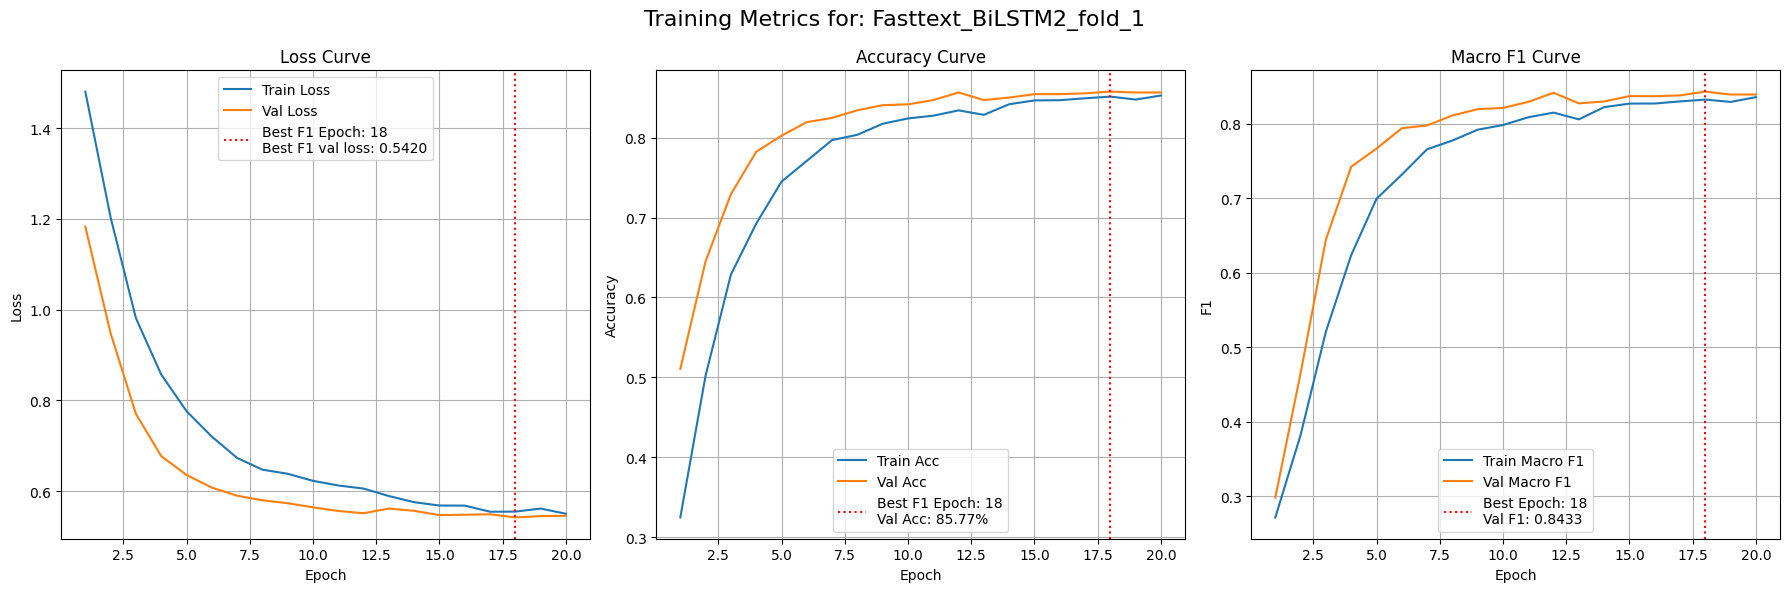

  Logging Fold 1 results under run_id: 32d3a7a73134418798ea8e90a29d471a
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM2_fold_1_state_dict.pt
Matthews correlation coefficient: 0.7986753858496376
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.93      0.90       379
LIGHT_PROFANITY       0.80      0.77      0.78       188
 HIGH_PROFANITY       0.84      0.82      0.83       120
       VIOLENCE       0.89      0.84      0.86       255

       accuracy                           0.86       942
      macro avg       0.85      0.84      0.84       942
   weighted avg       0.86      0.86      0.86       942

PR curve will be saved as Fasttext_BiLSTM2_fold_1_PR.png


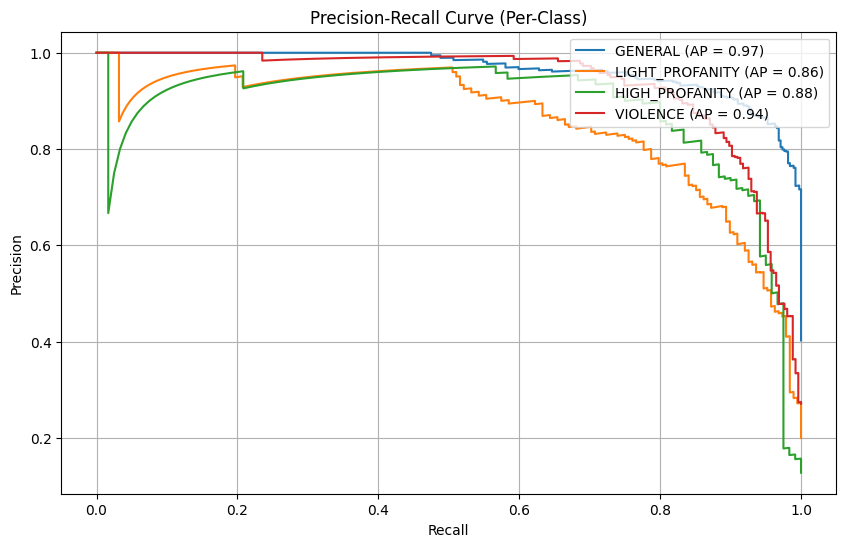

Confusion Matrix will be saved as Fasttext_BiLSTM2_fold_1_cm.png


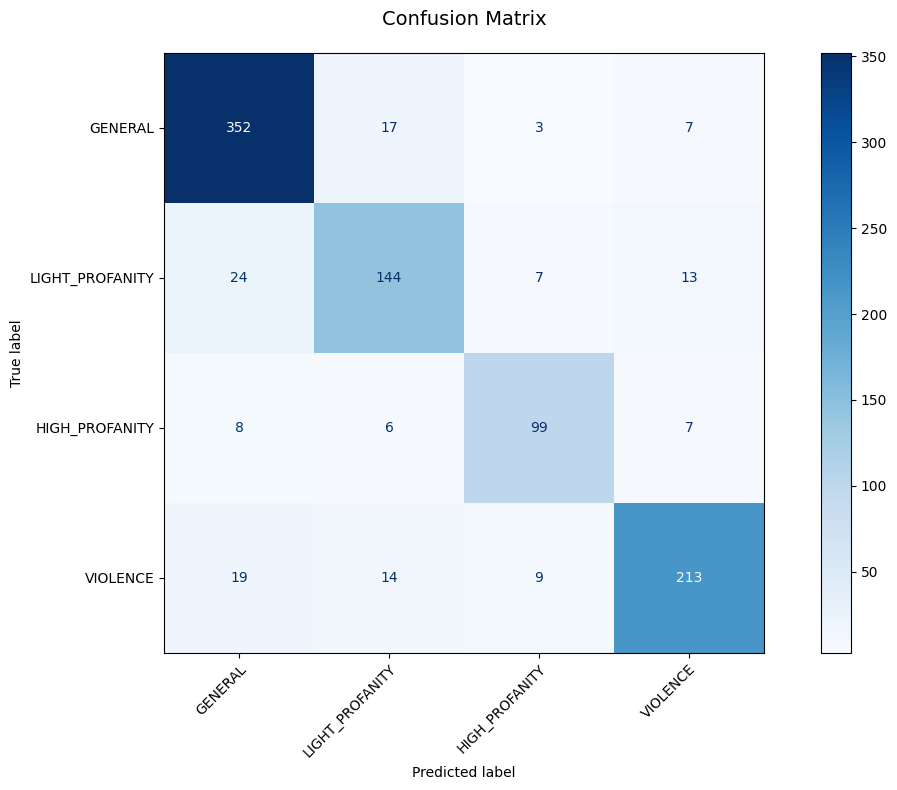

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/32d3a7a73134418798ea8e90a29d471a
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.5291 | Val Loss: 1.1775 | Train F1: 0.2462 | Val F1: 0.3353
Epoch 2/20 | Train Loss: 1.2342 | Val Loss: 0.9488 | Train F1: 0.3821 | Val F1: 0.4860
Epoch 3/20 | Train Loss: 1.0008 | Val Loss: 0.7775 | Train F1: 0.5222 | Val F1: 0.6642
Epoch 4/20 | Train Loss: 0.8636 | Val Loss: 0.7076 | Train F1: 0.6191 | Val F1: 0.7106
Epoch 5/20 | Train Loss: 0.7806 | Val Loss: 0.6382 | Train F1: 0.6874 | Val F1: 0.7802
Epoch 6/20 | Train Loss: 0.7356 | Val Loss: 0.6162 | Train F1: 0.7302 | Val F1: 0.7876
Epoch 7/20 | Train Loss: 0.6891 | Val Loss: 0.6125 | Train F1: 0.7552 | Val F1: 0.7977
Epoch 8/20 | Train Loss: 0.6618 | Val Loss: 0.5888 | Train F1: 0.7780 | Val F1: 0.8130
Epoch 9/20 | Train Loss: 0.6454 | Val Loss: 0.589

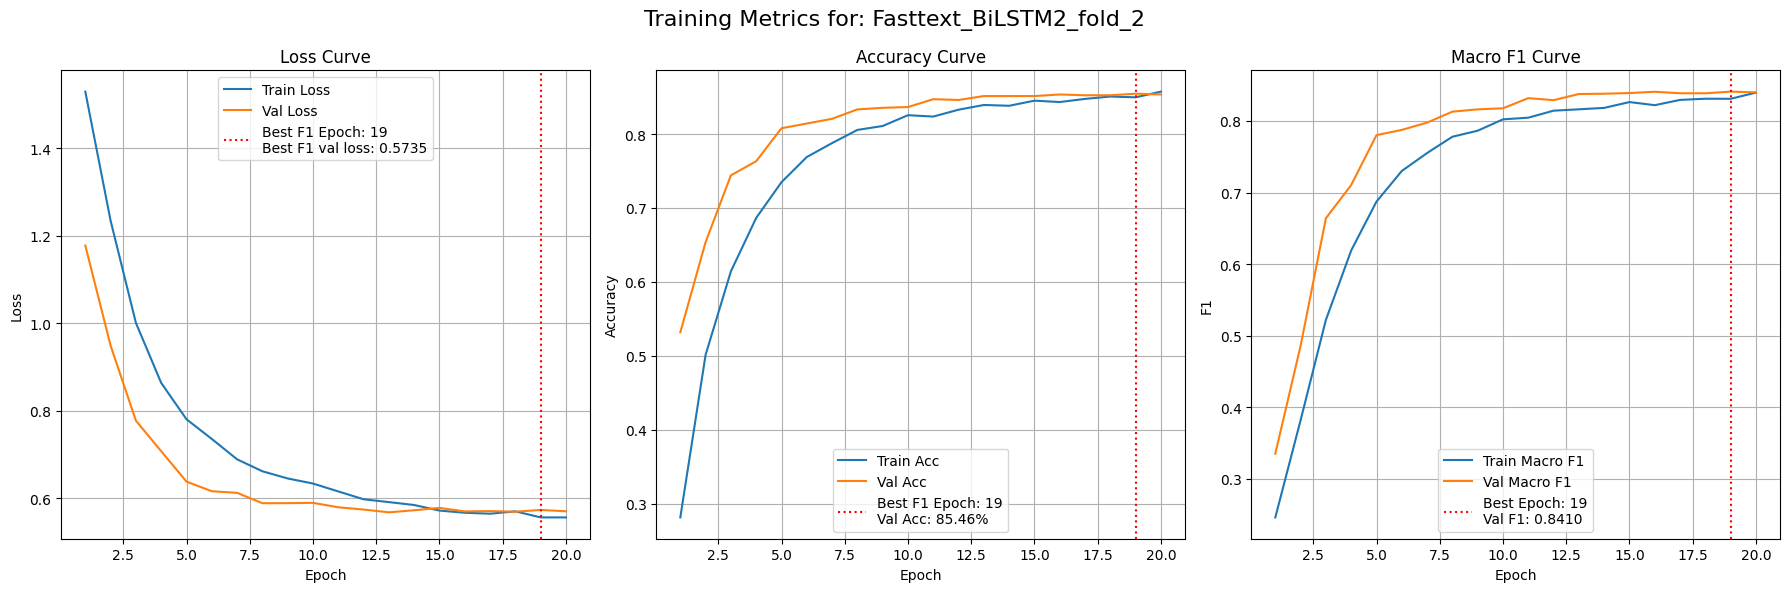

  Logging Fold 2 results under run_id: 06050c21d35a447aafe342956e44e36a
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM2_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7940628249828648
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.94      0.89       379
LIGHT_PROFANITY       0.82      0.75      0.79       187
 HIGH_PROFANITY       0.86      0.80      0.83       121
       VIOLENCE       0.89      0.83      0.86       255

       accuracy                           0.85       942
      macro avg       0.85      0.83      0.84       942
   weighted avg       0.86      0.85      0.85       942

PR curve will be saved as Fasttext_BiLSTM2_fold_2_PR.png


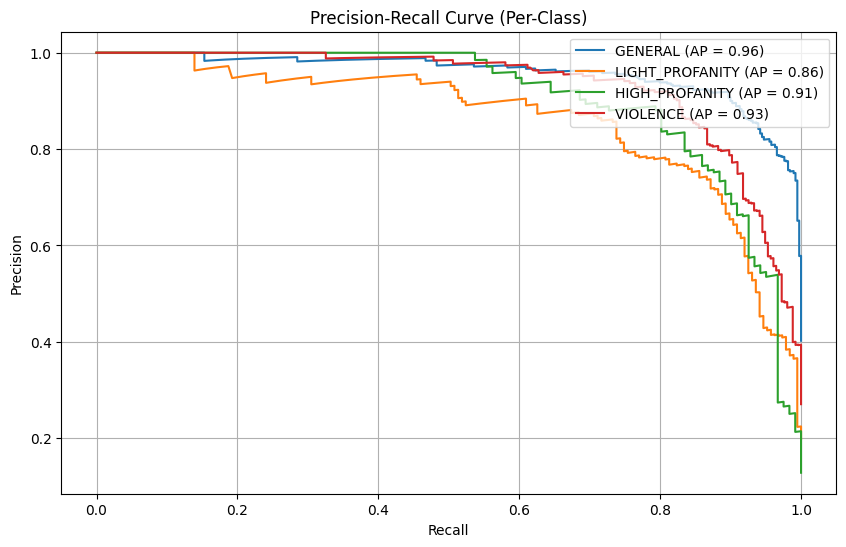

Confusion Matrix will be saved as Fasttext_BiLSTM2_fold_2_cm.png


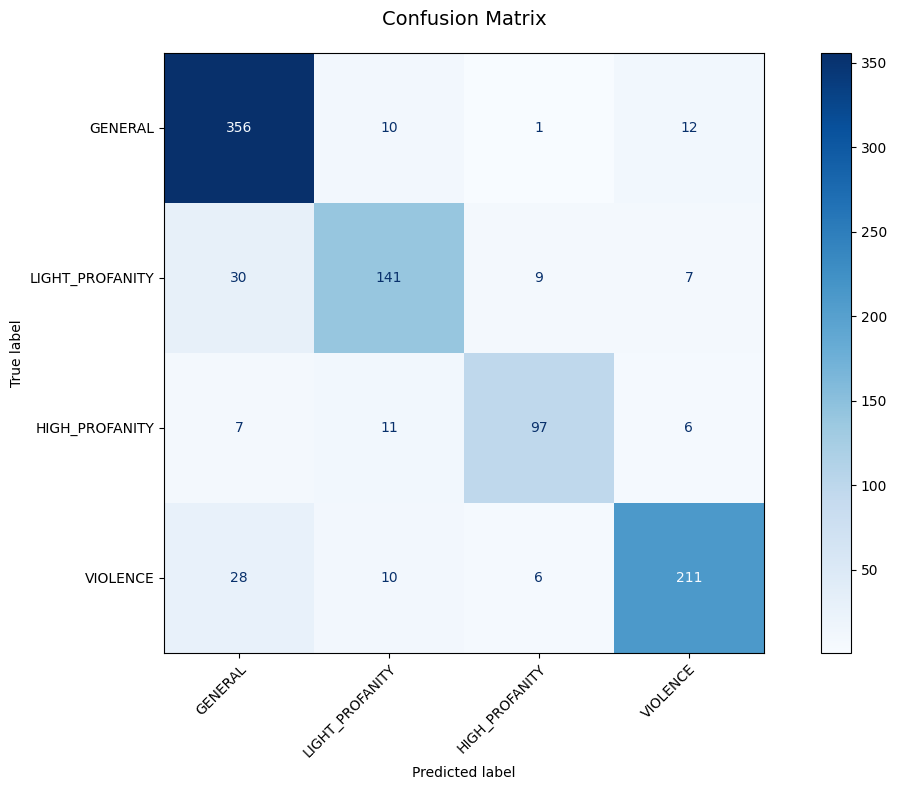

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/06050c21d35a447aafe342956e44e36a
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4691 | Val Loss: 1.1974 | Train F1: 0.2868 | Val F1: 0.3361
Epoch 2/20 | Train Loss: 1.2039 | Val Loss: 0.9653 | Train F1: 0.3877 | Val F1: 0.4156
Epoch 3/20 | Train Loss: 0.9723 | Val Loss: 0.8178 | Train F1: 0.5260 | Val F1: 0.6282
Epoch 4/20 | Train Loss: 0.8387 | Val Loss: 0.7324 | Train F1: 0.6363 | Val F1: 0.7009
Epoch 5/20 | Train Loss: 0.7480 | Val Loss: 0.6986 | Train F1: 0.7136 | Val F1: 0.7393
Epoch 6/20 | Train Loss: 0.6943 | Val Loss: 0.6795 | Train F1: 0.7538 | Val F1: 0.7561
Epoch 7/20 | Train Loss: 0.6570 | Val Loss: 0.6654 | Train F1: 0.7781 | Val F1: 0.7802
Epoch 8/20 | Train Loss: 0.6239 | Val Loss: 0.6578 | Train F1: 0.7997 | Val F1: 0.7845
Epoch 9/20 | Train Loss: 0.6077 | Val Loss: 0.655

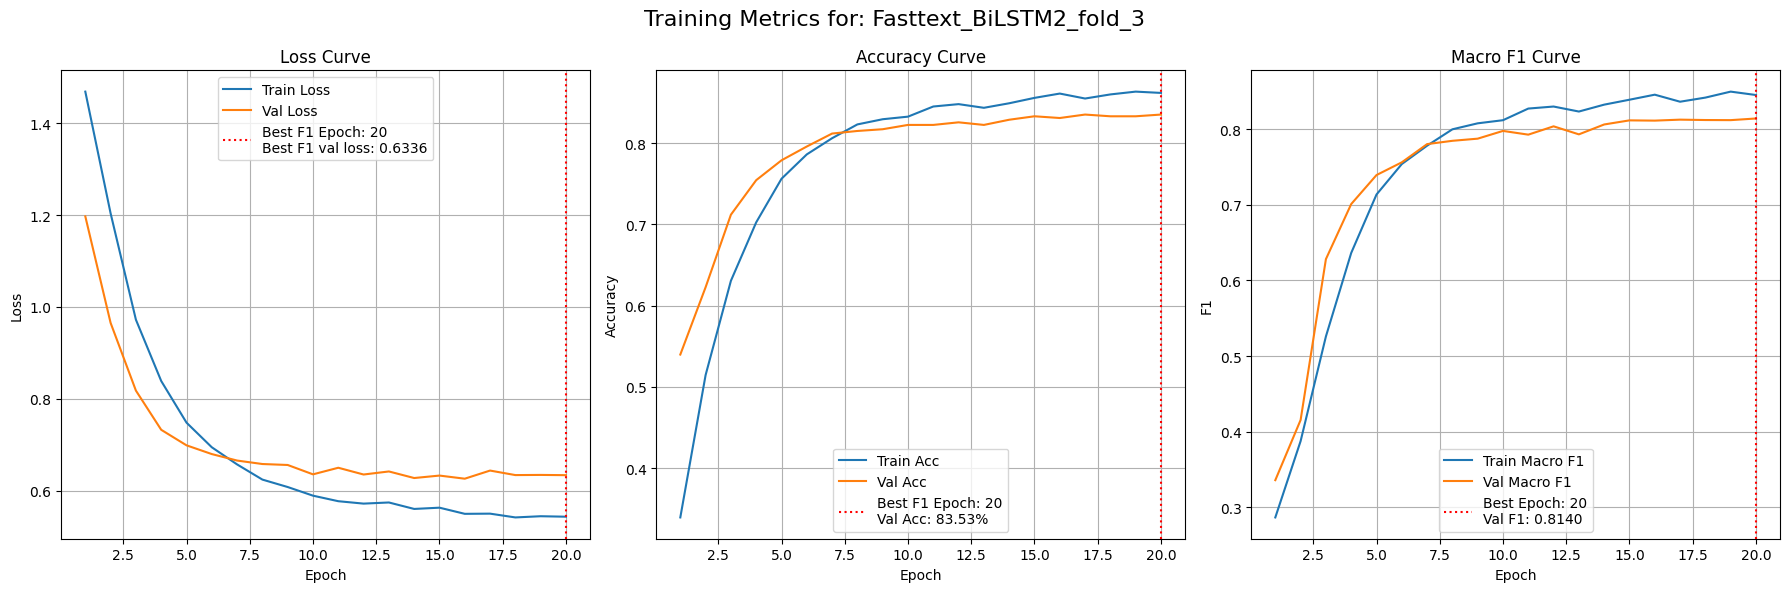

  Logging Fold 3 results under run_id: 9161970b052a45a998fb10fec152a98b
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM2_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7665838430410075
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.96      0.90       379
LIGHT_PROFANITY       0.83      0.73      0.78       187
 HIGH_PROFANITY       0.80      0.77      0.78       120
       VIOLENCE       0.83      0.76      0.80       255

       accuracy                           0.84       941
      macro avg       0.83      0.80      0.81       941
   weighted avg       0.83      0.84      0.83       941

PR curve will be saved as Fasttext_BiLSTM2_fold_3_PR.png


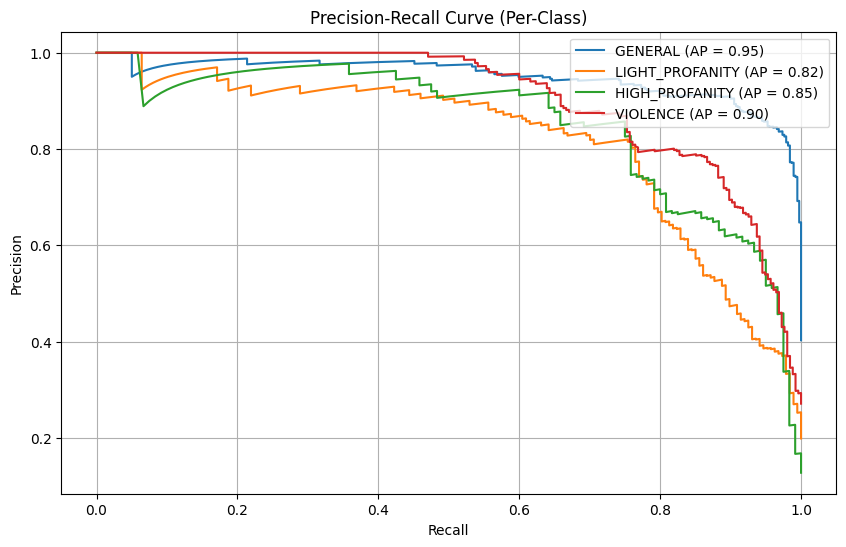

Confusion Matrix will be saved as Fasttext_BiLSTM2_fold_3_cm.png


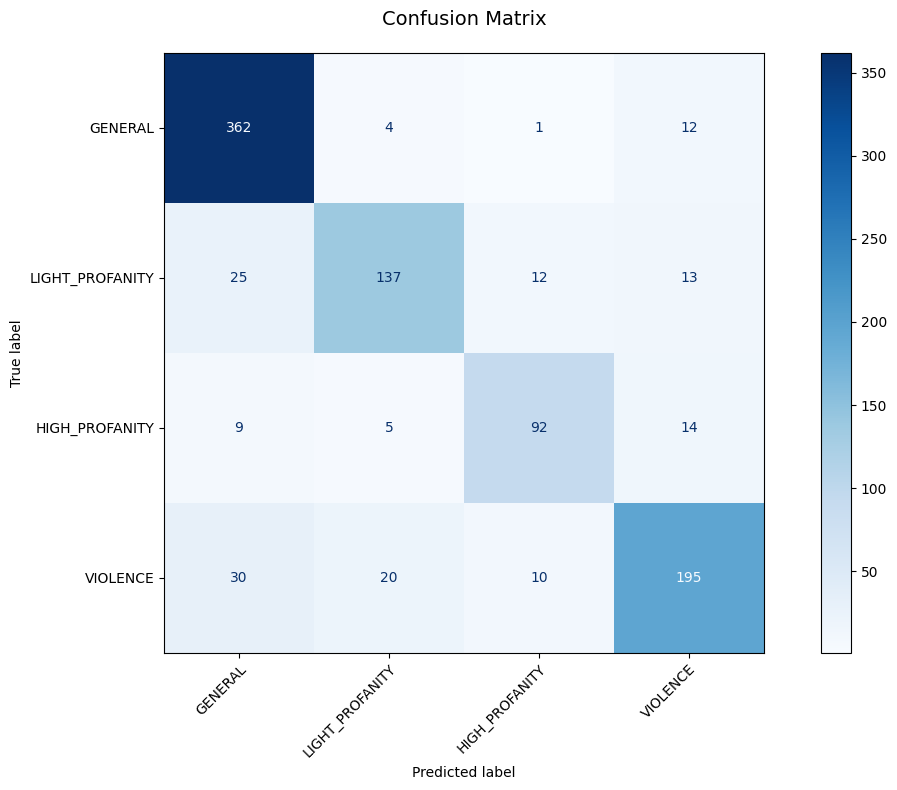

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/9161970b052a45a998fb10fec152a98b
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.5518 | Val Loss: 1.2189 | Train F1: 0.2567 | Val F1: 0.3293
Epoch 2/20 | Train Loss: 1.2326 | Val Loss: 0.9759 | Train F1: 0.3658 | Val F1: 0.4389
Epoch 3/20 | Train Loss: 1.0225 | Val Loss: 0.8110 | Train F1: 0.5095 | Val F1: 0.6016
Epoch 4/20 | Train Loss: 0.8772 | Val Loss: 0.7172 | Train F1: 0.6012 | Val F1: 0.7117
Epoch 5/20 | Train Loss: 0.7813 | Val Loss: 0.6703 | Train F1: 0.6841 | Val F1: 0.7468
Epoch 6/20 | Train Loss: 0.7214 | Val Loss: 0.6436 | Train F1: 0.7281 | Val F1: 0.7704
Epoch 7/20 | Train Loss: 0.6784 | Val Loss: 0.6206 | Train F1: 0.7558 | Val F1: 0.7805
Epoch 8/20 | Train Loss: 0.6464 | Val Loss: 0.6086 | Train F1: 0.7847 | Val F1: 0.7901
Epoch 9/20 | Train Loss: 0.6267 | Val Loss: 0.598

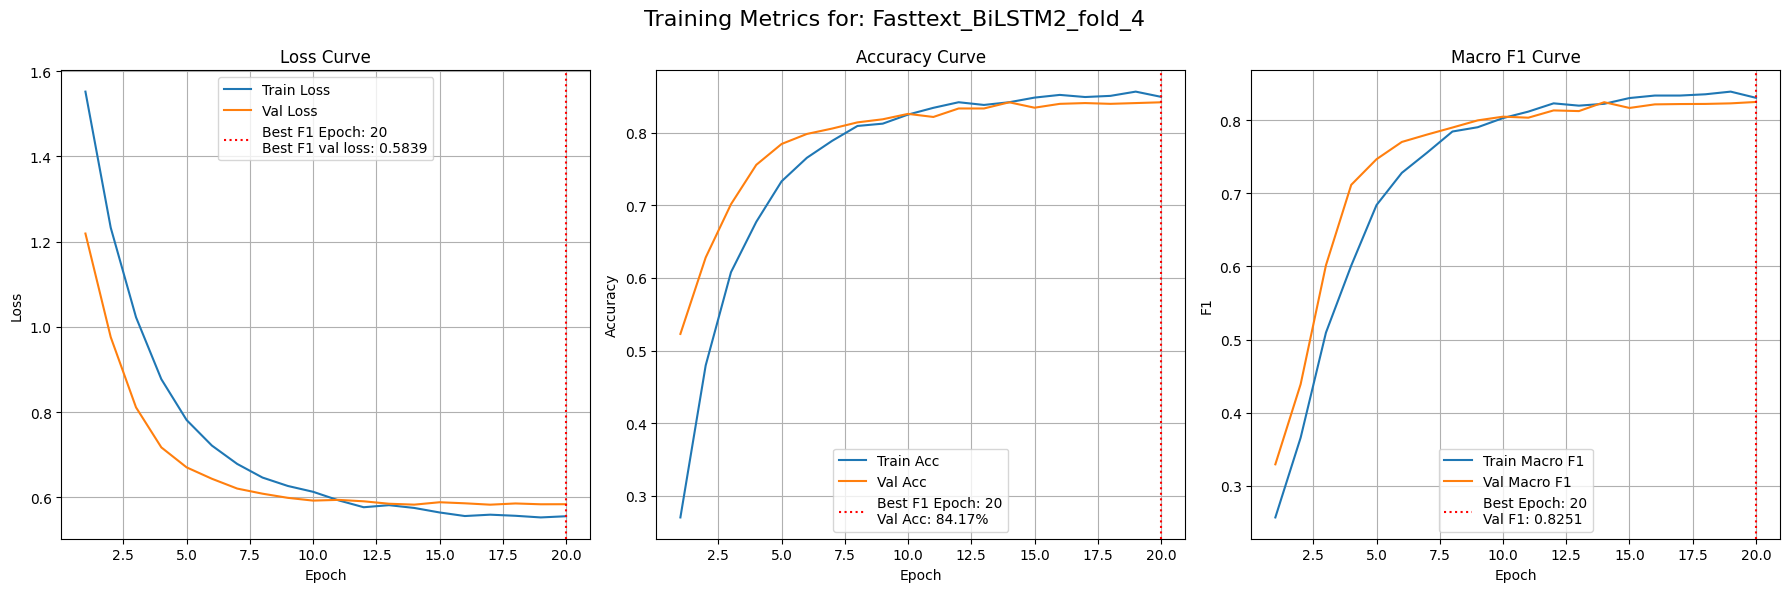

  Logging Fold 4 results under run_id: deedf39ee3034a868226b733bb6897af
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM2_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7761283424838228
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.92      0.88       378
LIGHT_PROFANITY       0.82      0.74      0.78       188
 HIGH_PROFANITY       0.78      0.81      0.80       120
       VIOLENCE       0.88      0.81      0.84       255

       accuracy                           0.84       941
      macro avg       0.83      0.82      0.83       941
   weighted avg       0.84      0.84      0.84       941

PR curve will be saved as Fasttext_BiLSTM2_fold_4_PR.png


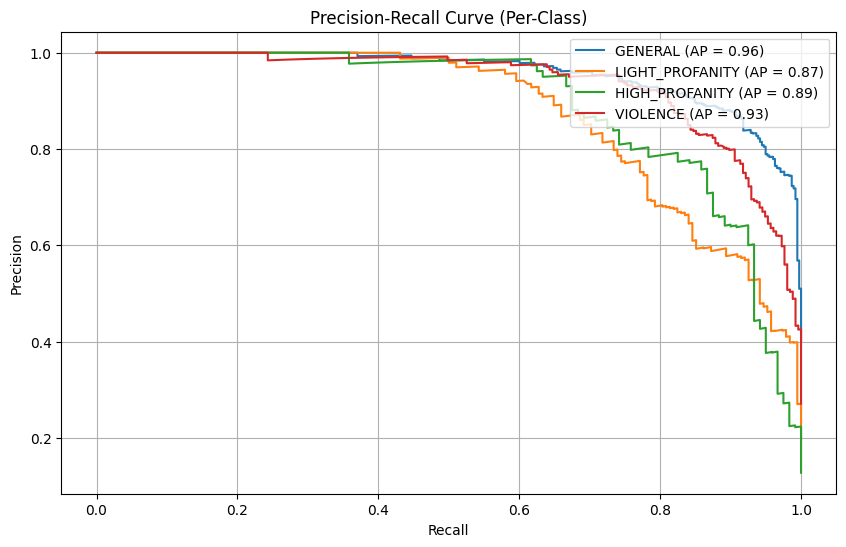

Confusion Matrix will be saved as Fasttext_BiLSTM2_fold_4_cm.png


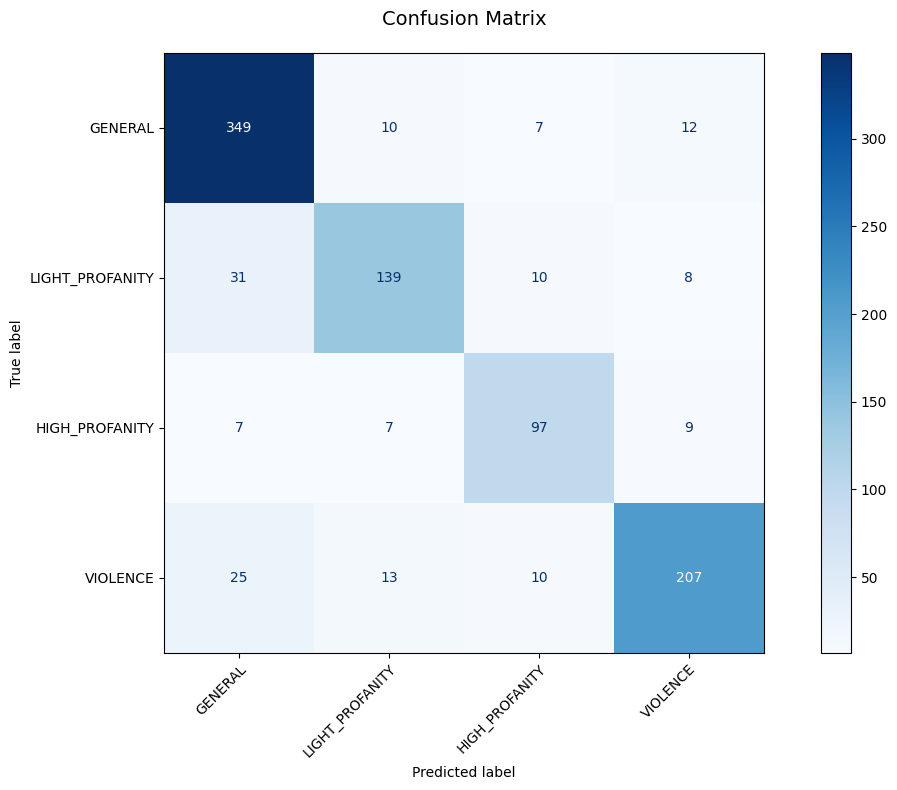

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/deedf39ee3034a868226b733bb6897af
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.5947 | Val Loss: 1.2546 | Train F1: 0.2399 | Val F1: 0.2696
Epoch 2/20 | Train Loss: 1.2378 | Val Loss: 0.9975 | Train F1: 0.3788 | Val F1: 0.4207
Epoch 3/20 | Train Loss: 1.0061 | Val Loss: 0.8371 | Train F1: 0.5102 | Val F1: 0.5914
Epoch 4/20 | Train Loss: 0.8761 | Val Loss: 0.7627 | Train F1: 0.6172 | Val F1: 0.6847
Epoch 5/20 | Train Loss: 0.7645 | Val Loss: 0.7217 | Train F1: 0.7011 | Val F1: 0.7262
Epoch 6/20 | Train Loss: 0.7059 | Val Loss: 0.7040 | Train F1: 0.7441 | Val F1: 0.7581
Epoch 7/20 | Train Loss: 0.6678 | Val Loss: 0.7012 | Train F1: 0.7714 | Val F1: 0.7653
Epoch 8/20 | Train Loss: 0.6460 | Val Loss: 0.6952 | Train F1: 0.7888 | Val F1: 0.7583
Epoch 9/20 | Train Loss: 0.6260 | Val Loss: 0.681

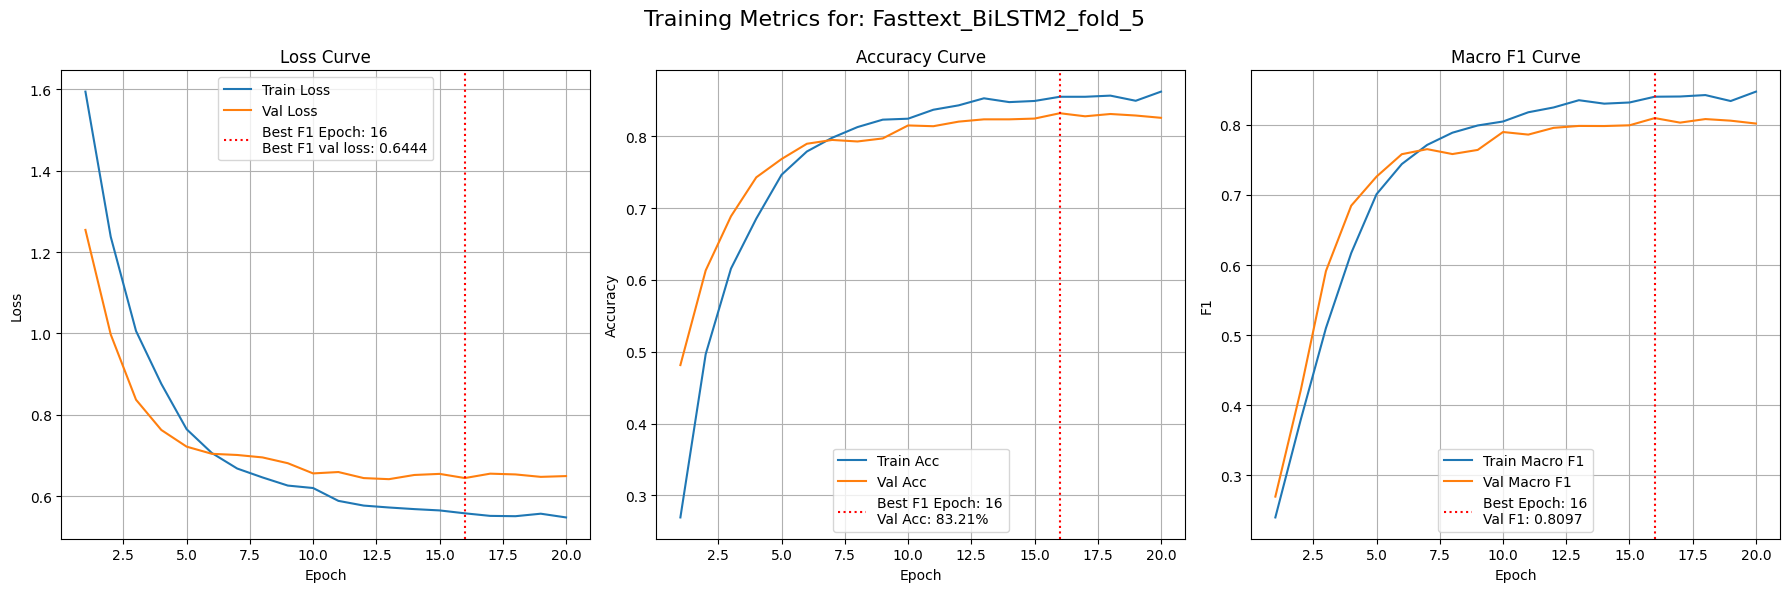

  Logging Fold 5 results under run_id: a7a97a666c404dd08cb03b70984fd07a
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM2_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7615306591394501
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.94      0.90       378
LIGHT_PROFANITY       0.76      0.72      0.74       188
 HIGH_PROFANITY       0.85      0.72      0.78       120
       VIOLENCE       0.84      0.80      0.82       255

       accuracy                           0.83       941
      macro avg       0.83      0.80      0.81       941
   weighted avg       0.83      0.83      0.83       941

PR curve will be saved as Fasttext_BiLSTM2_fold_5_PR.png


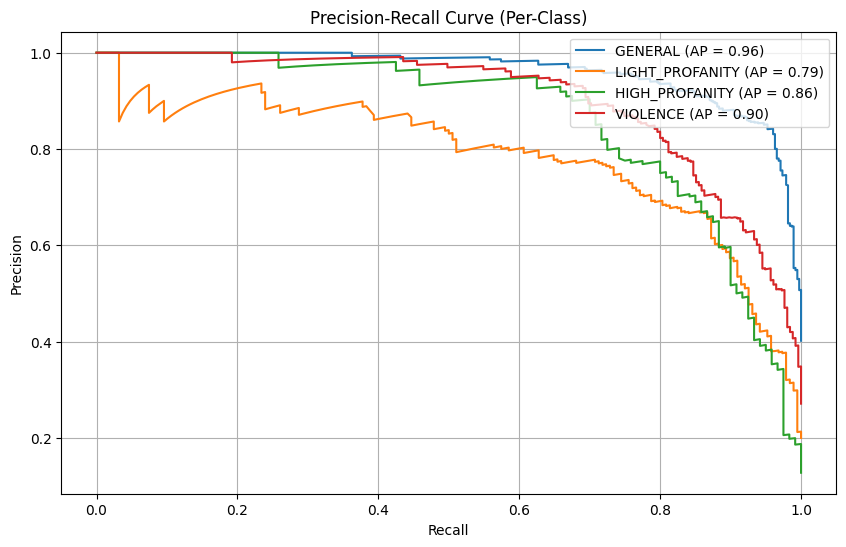

Confusion Matrix will be saved as Fasttext_BiLSTM2_fold_5_cm.png


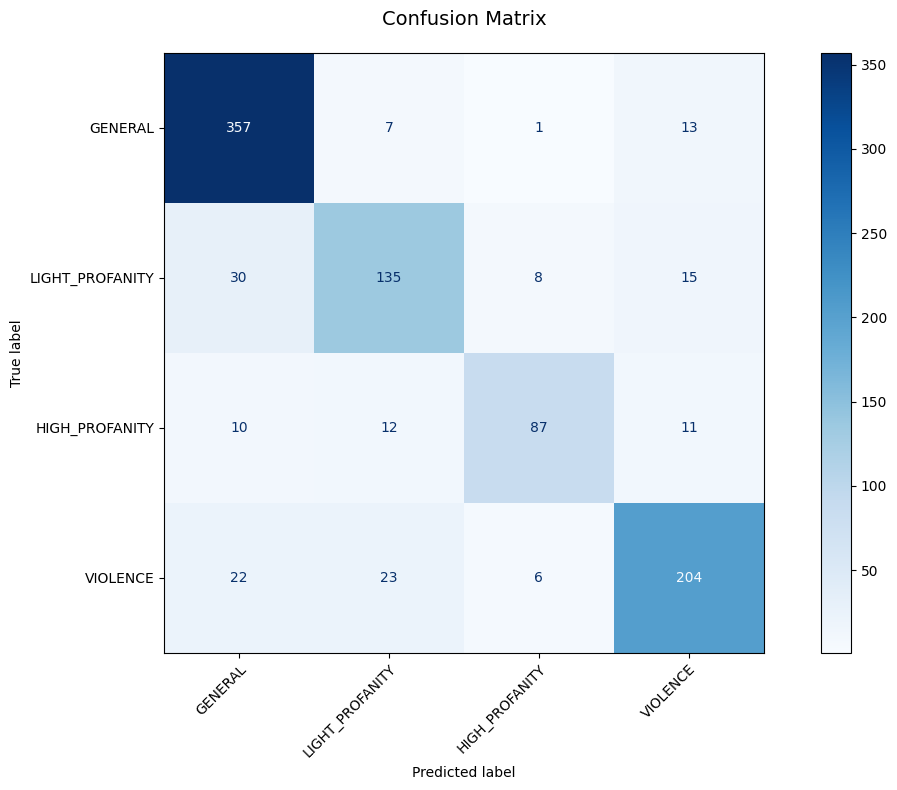

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/a7a97a666c404dd08cb03b70984fd07a
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for Fasttext_BiLSTM2 across 5 folds...
Overall Results for Fasttext_BiLSTM2:
  Avg Accuracy: 0.8443
  Avg Macro F1: 0.8266
  Avg Macro precision: 0.8379
  Avg Macro recall: 0.8183
  Avg Weighted F1: 0.8425
  Avg MCC: 0.7794

Performing Overall Out-of-Fold Evaluation for Fasttext_BiLSTM2...
Overall Out-of-Fold Classification Report for Fasttext_BiLSTM2:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.94      0.89      1893
LIGHT_PROFANITY       0.80      0.74      0.77       938
 HIGH_PROFANITY       0.83      0.79      0.80       601
       VIOLENCE       0.87      0.81      0.84      1275

       accuracy                           0.84      4707
      macro avg       0.8

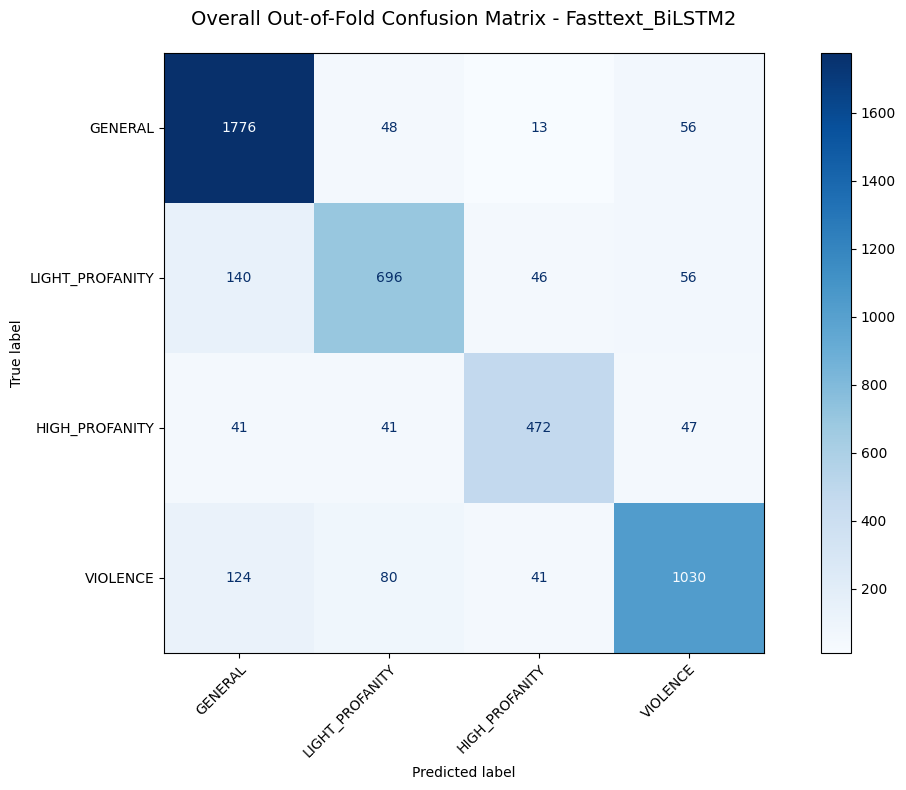

🏃 View run Fasttext_BiLSTM2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/fddced3013da49f385f02f896ed08f03
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [17]:
BiLSTM2_cv_outputs = run_cross_validation(architectures_to_test[0], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

# BiLSTM cross validation


Starting Cross-Validation for: Fasttext_BiLSTM
Epoch 1/20 | Train Loss: 1.4310 | Val Loss: 1.2213 | Train F1: 0.2583 | Val F1: 0.3231
Epoch 2/20 | Train Loss: 1.1590 | Val Loss: 1.0179 | Train F1: 0.3893 | Val F1: 0.4370
Epoch 3/20 | Train Loss: 0.9723 | Val Loss: 0.8580 | Train F1: 0.5083 | Val F1: 0.5509
Epoch 4/20 | Train Loss: 0.8362 | Val Loss: 0.7295 | Train F1: 0.6260 | Val F1: 0.6881
Epoch 5/20 | Train Loss: 0.7380 | Val Loss: 0.6856 | Train F1: 0.7059 | Val F1: 0.7440
Epoch 6/20 | Train Loss: 0.6697 | Val Loss: 0.6190 | Train F1: 0.7612 | Val F1: 0.7866
Epoch 7/20 | Train Loss: 0.6371 | Val Loss: 0.5842 | Train F1: 0.7867 | Val F1: 0.8159
Epoch 8/20 | Train Loss: 0.6104 | Val Loss: 0.5820 | Train F1: 0.7885 | Val F1: 0.8209
Epoch 9/20 | Train Loss: 0.5889 | Val Loss: 0.5669 | Train F1: 0.8168 | Val F1: 0.8250
Epoch 10/20 | Train Loss: 0.5740 | Val Loss: 0.5542 | Train F1: 0.8277 | Val F1: 0.8347
Epoch 11/20 | Train Loss: 0.5655 | Val Loss: 0.5529 | Train F1: 0.8252 | Val F1: 

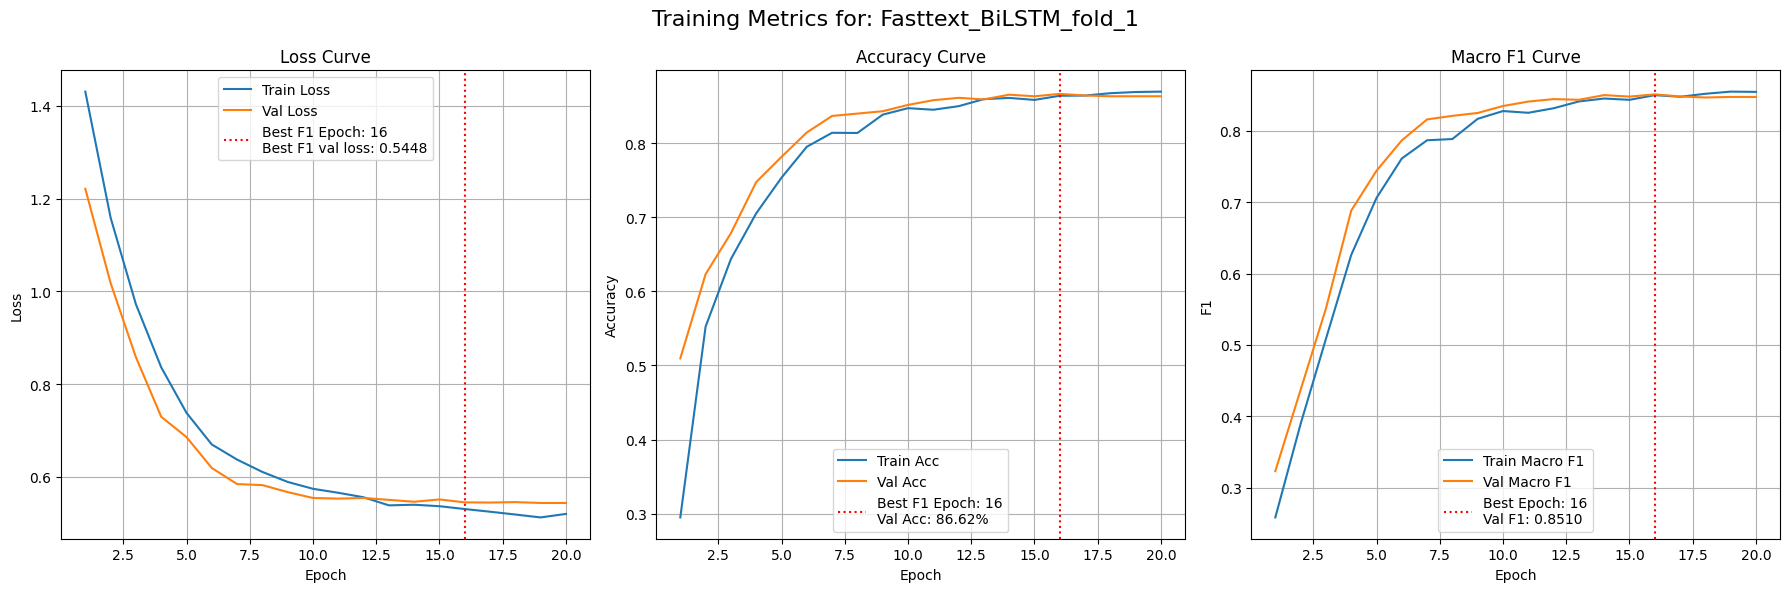

  Logging Fold 1 results under run_id: ac880728f6ed4b808c5d8fc05b6d5bbb
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_fold_1_state_dict.pt
Matthews correlation coefficient: 0.8108015671234411
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.88      0.95      0.92       379
LIGHT_PROFANITY       0.81      0.77      0.79       188
 HIGH_PROFANITY       0.85      0.84      0.85       120
       VIOLENCE       0.89      0.82      0.85       255

       accuracy                           0.87       942
      macro avg       0.86      0.85      0.85       942
   weighted avg       0.87      0.87      0.86       942

PR curve will be saved as Fasttext_BiLSTM_fold_1_PR.png


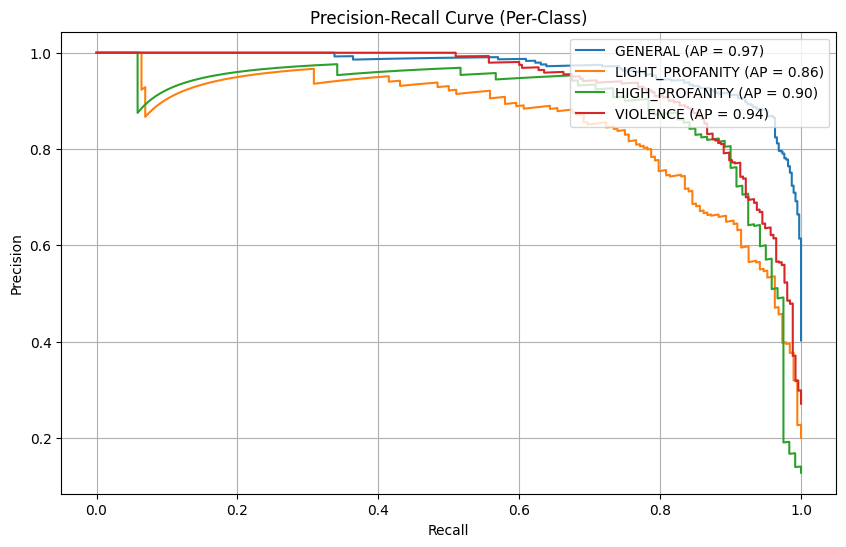

Confusion Matrix will be saved as Fasttext_BiLSTM_fold_1_cm.png


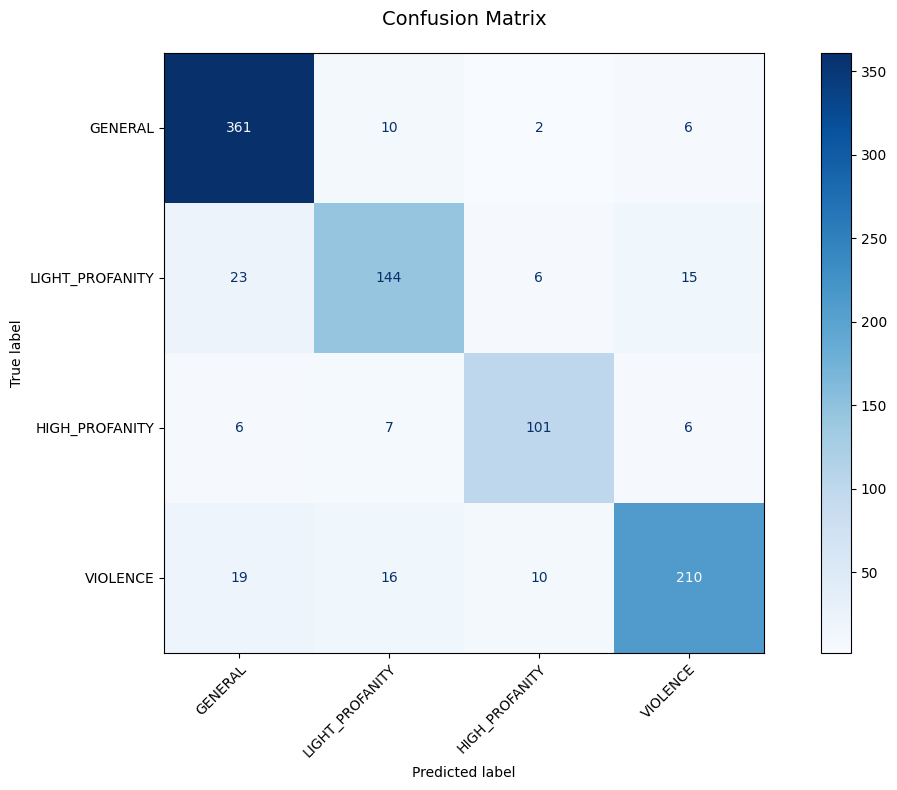

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/ac880728f6ed4b808c5d8fc05b6d5bbb
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4157 | Val Loss: 1.2441 | Train F1: 0.2531 | Val F1: 0.2972
Epoch 2/20 | Train Loss: 1.1889 | Val Loss: 1.0457 | Train F1: 0.3502 | Val F1: 0.4174
Epoch 3/20 | Train Loss: 1.0025 | Val Loss: 0.8704 | Train F1: 0.4793 | Val F1: 0.5319
Epoch 4/20 | Train Loss: 0.8458 | Val Loss: 0.7430 | Train F1: 0.6055 | Val F1: 0.6862
Epoch 5/20 | Train Loss: 0.7539 | Val Loss: 0.6781 | Train F1: 0.6835 | Val F1: 0.7373
Epoch 6/20 | Train Loss: 0.6838 | Val Loss: 0.6391 | Train F1: 0.7409 | Val F1: 0.7817
Epoch 7/20 | Train Loss: 0.6370 | Val Loss: 0.6397 | Train F1: 0.7731 | Val F1: 0.7760
Epoch 8/20 | Train Loss: 0.6086 | Val Loss: 0.6160 | Train F1: 0.7955 | Val F1: 0.7957
Epoch 9/20 | Train Loss: 0.5968 | Val Loss: 0.624

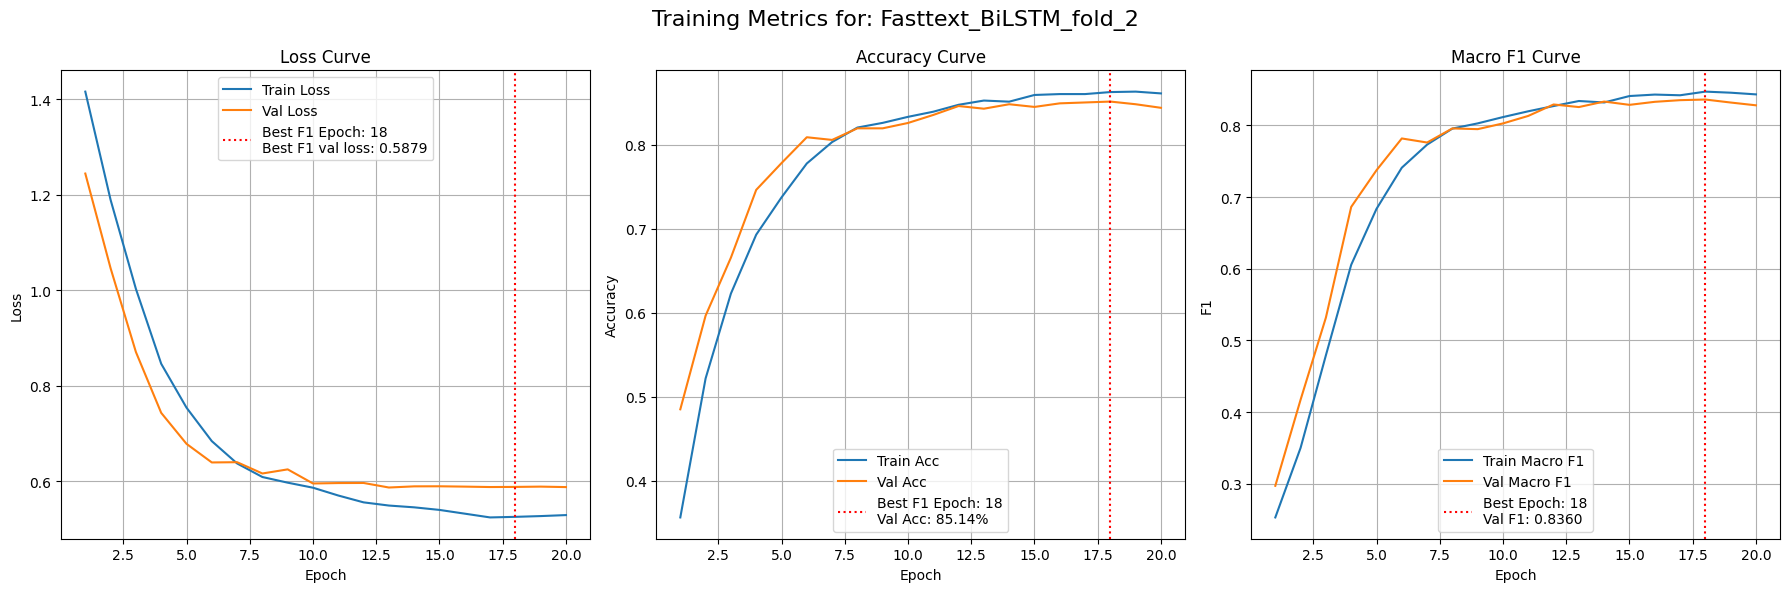

  Logging Fold 2 results under run_id: bf5a5ad4a55441abb57a88d8ccc965c0
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7897041909853876
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.94      0.90       379
LIGHT_PROFANITY       0.80      0.74      0.77       187
 HIGH_PROFANITY       0.84      0.82      0.83       121
       VIOLENCE       0.89      0.82      0.85       255

       accuracy                           0.85       942
      macro avg       0.85      0.83      0.84       942
   weighted avg       0.85      0.85      0.85       942

PR curve will be saved as Fasttext_BiLSTM_fold_2_PR.png


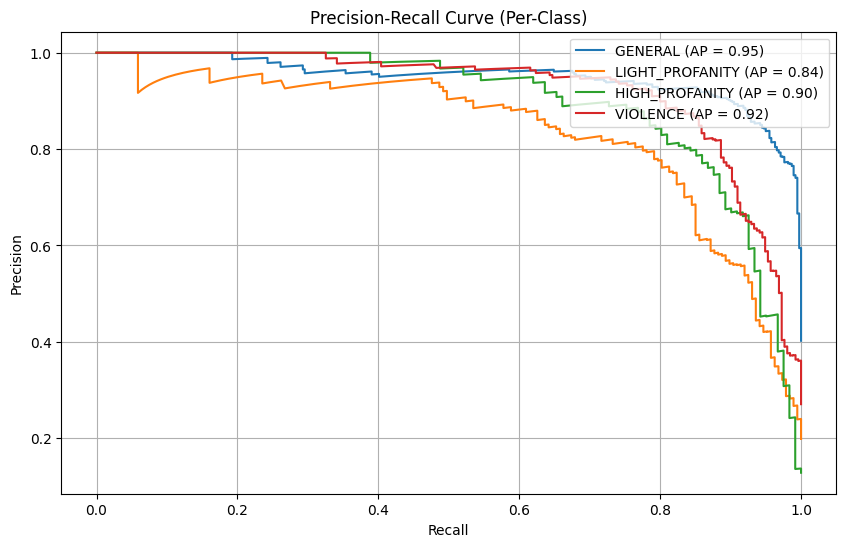

Confusion Matrix will be saved as Fasttext_BiLSTM_fold_2_cm.png


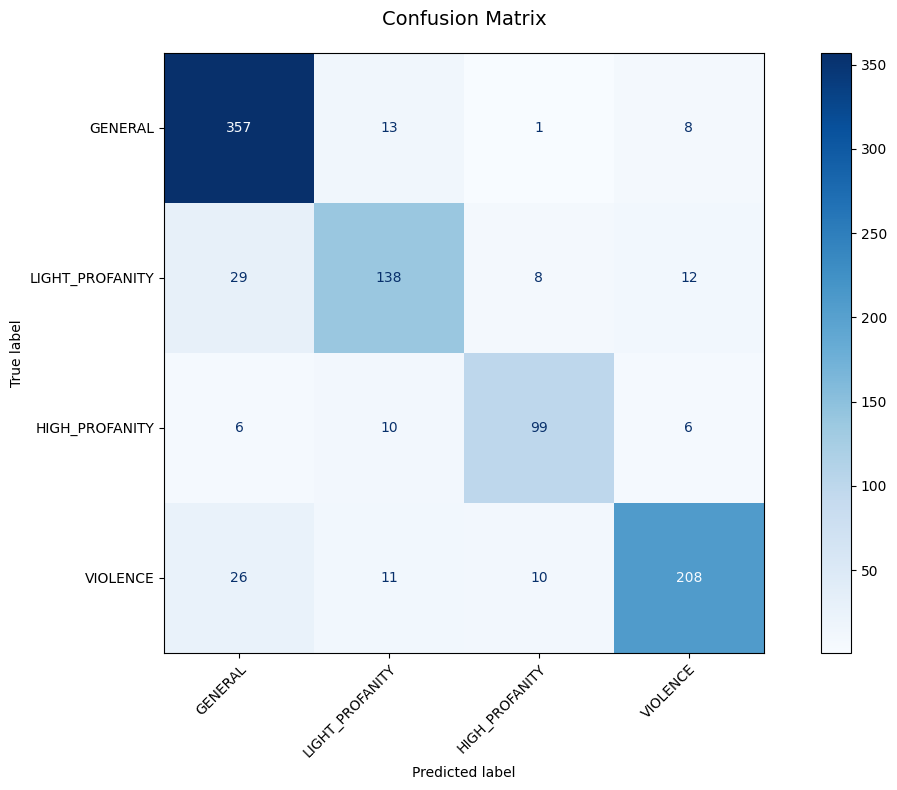

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/bf5a5ad4a55441abb57a88d8ccc965c0
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4079 | Val Loss: 1.2252 | Train F1: 0.2328 | Val F1: 0.2862
Epoch 2/20 | Train Loss: 1.1615 | Val Loss: 1.0425 | Train F1: 0.3723 | Val F1: 0.3809
Epoch 3/20 | Train Loss: 0.9821 | Val Loss: 0.8802 | Train F1: 0.4847 | Val F1: 0.5417
Epoch 4/20 | Train Loss: 0.8394 | Val Loss: 0.7743 | Train F1: 0.6228 | Val F1: 0.6574
Epoch 5/20 | Train Loss: 0.7246 | Val Loss: 0.6942 | Train F1: 0.7263 | Val F1: 0.7416
Epoch 6/20 | Train Loss: 0.6630 | Val Loss: 0.6583 | Train F1: 0.7687 | Val F1: 0.7599
Epoch 7/20 | Train Loss: 0.6220 | Val Loss: 0.6379 | Train F1: 0.7926 | Val F1: 0.7745
Epoch 8/20 | Train Loss: 0.5974 | Val Loss: 0.6302 | Train F1: 0.8107 | Val F1: 0.7873
Epoch 9/20 | Train Loss: 0.5778 | Val Loss: 0.621

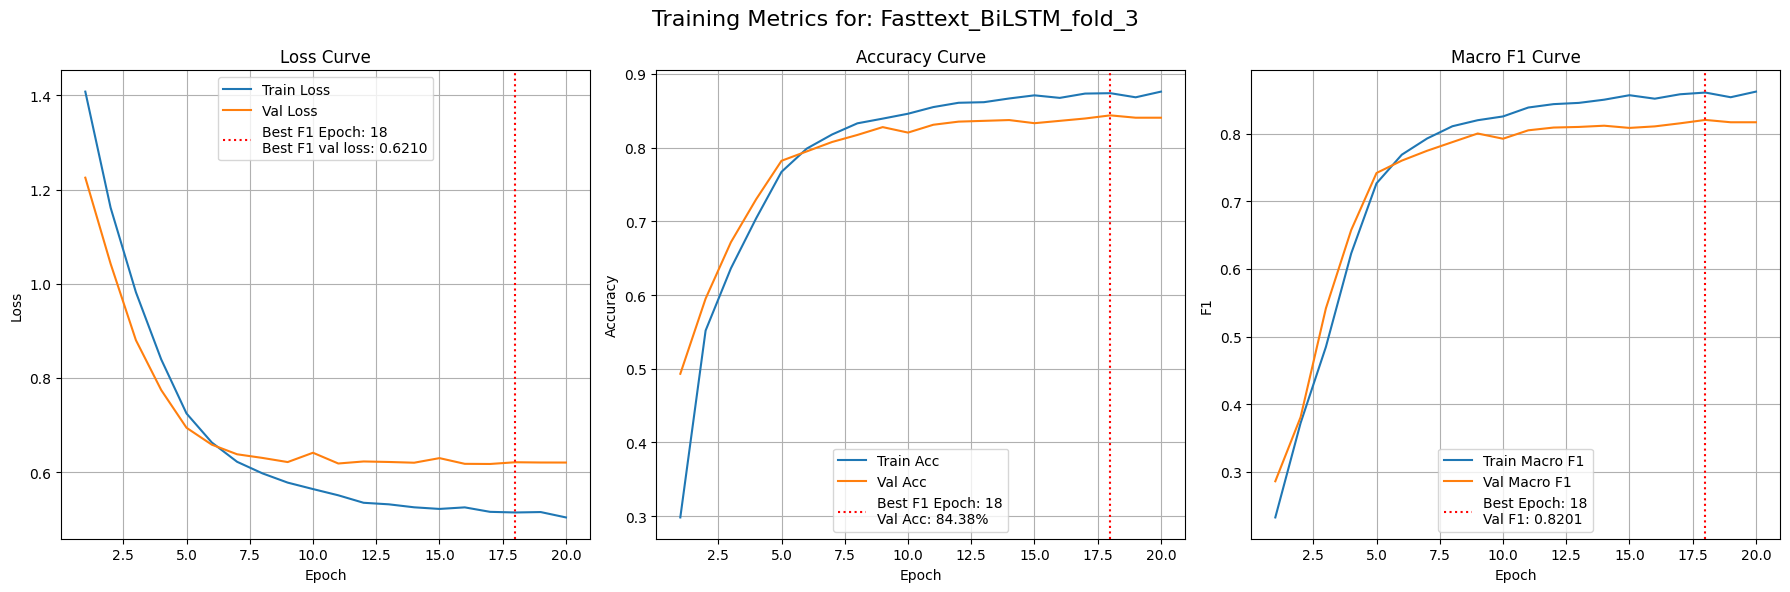

  Logging Fold 3 results under run_id: 7828f662b73141678262e41171631467
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7788246350896553
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.96      0.91       379
LIGHT_PROFANITY       0.83      0.72      0.77       187
 HIGH_PROFANITY       0.78      0.78      0.78       120
       VIOLENCE       0.85      0.79      0.82       255

       accuracy                           0.84       941
      macro avg       0.83      0.81      0.82       941
   weighted avg       0.84      0.84      0.84       941

PR curve will be saved as Fasttext_BiLSTM_fold_3_PR.png


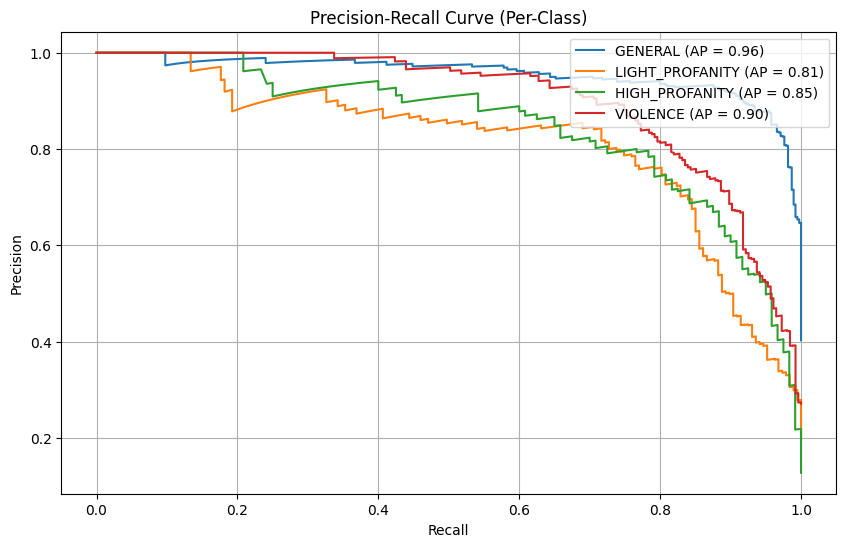

Confusion Matrix will be saved as Fasttext_BiLSTM_fold_3_cm.png


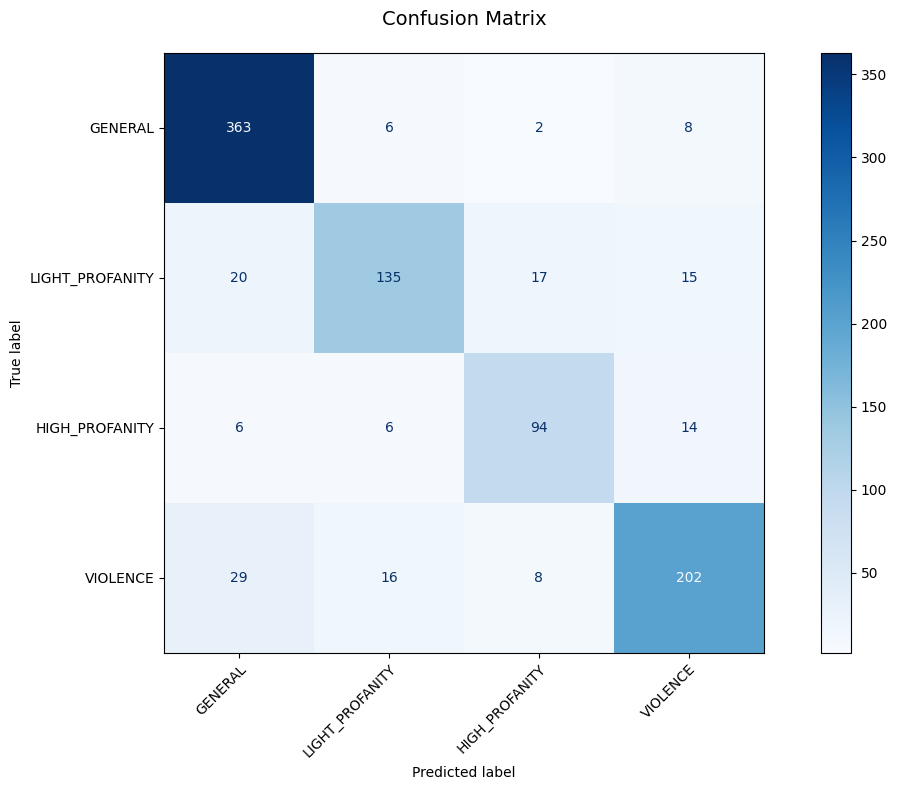

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/7828f662b73141678262e41171631467
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4677 | Val Loss: 1.3154 | Train F1: 0.1901 | Val F1: 0.2172
Epoch 2/20 | Train Loss: 1.2234 | Val Loss: 1.0908 | Train F1: 0.3272 | Val F1: 0.3549
Epoch 3/20 | Train Loss: 1.0272 | Val Loss: 0.8945 | Train F1: 0.4387 | Val F1: 0.4784
Epoch 4/20 | Train Loss: 0.8768 | Val Loss: 0.7822 | Train F1: 0.5945 | Val F1: 0.6475
Epoch 5/20 | Train Loss: 0.7656 | Val Loss: 0.6967 | Train F1: 0.6896 | Val F1: 0.7544
Epoch 6/20 | Train Loss: 0.6994 | Val Loss: 0.6547 | Train F1: 0.7410 | Val F1: 0.7695
Epoch 7/20 | Train Loss: 0.6548 | Val Loss: 0.6295 | Train F1: 0.7734 | Val F1: 0.7880
Epoch 8/20 | Train Loss: 0.6230 | Val Loss: 0.6134 | Train F1: 0.7878 | Val F1: 0.7979
Epoch 9/20 | Train Loss: 0.6030 | Val Loss: 0.608

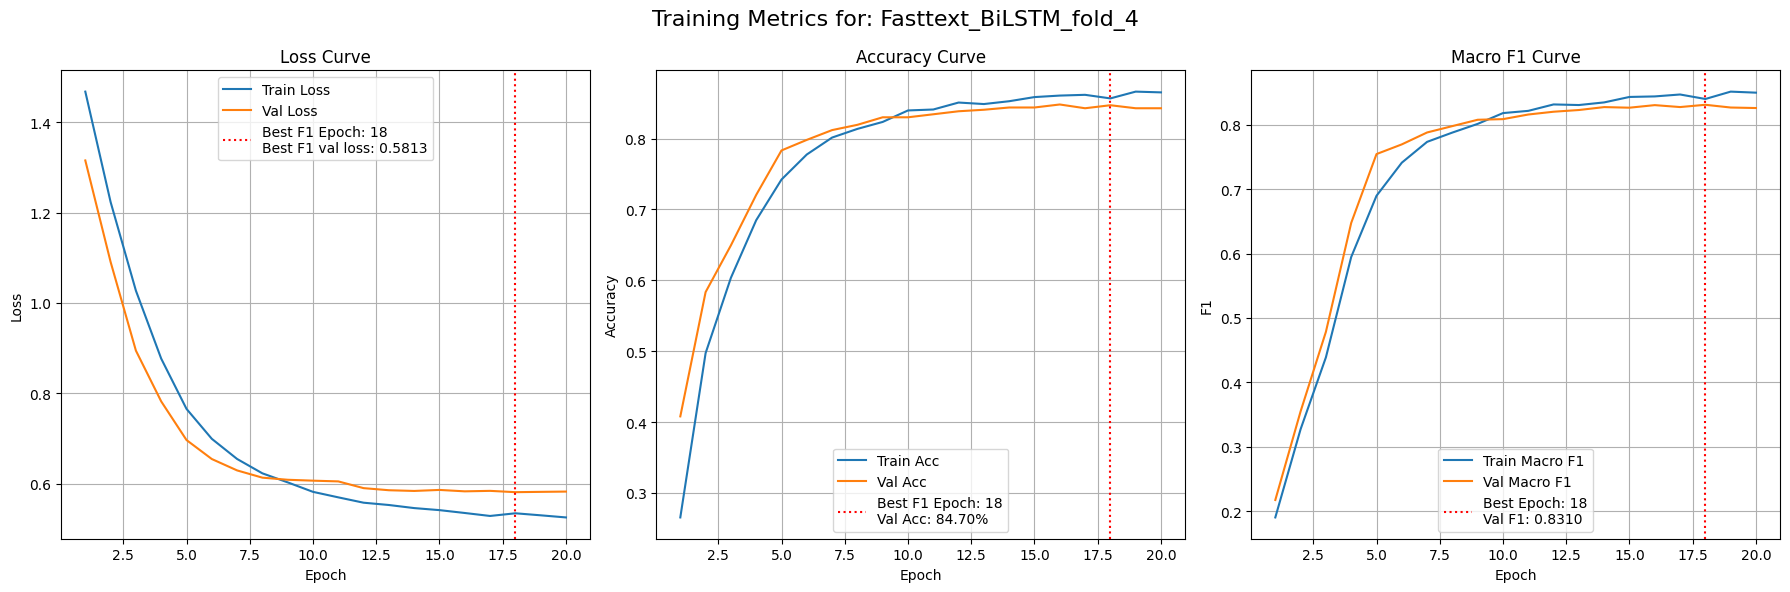

  Logging Fold 4 results under run_id: 16da3a47cf0d4826a8f12c516fba55a7
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7835329666319449
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.92      0.89       378
LIGHT_PROFANITY       0.81      0.73      0.77       188
 HIGH_PROFANITY       0.80      0.82      0.81       120
       VIOLENCE       0.88      0.84      0.86       255

       accuracy                           0.85       941
      macro avg       0.84      0.83      0.83       941
   weighted avg       0.85      0.85      0.85       941

PR curve will be saved as Fasttext_BiLSTM_fold_4_PR.png


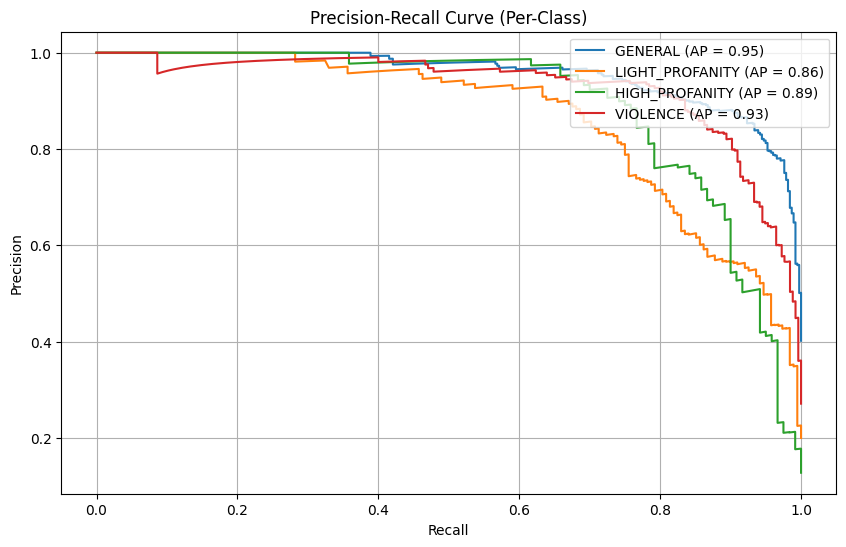

Confusion Matrix will be saved as Fasttext_BiLSTM_fold_4_cm.png


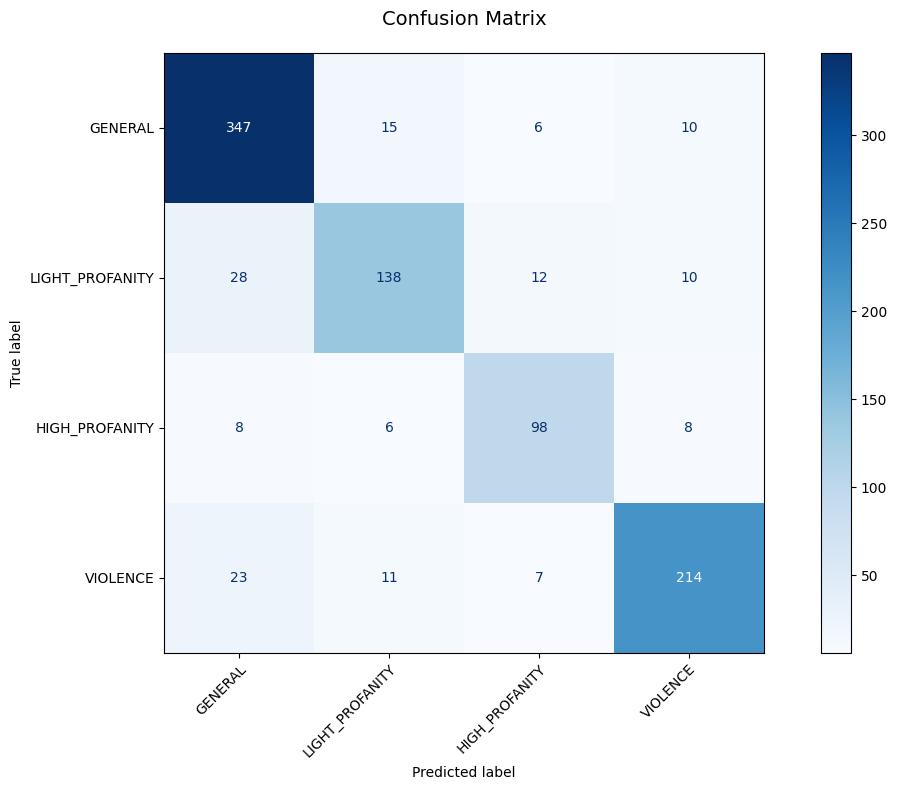

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/16da3a47cf0d4826a8f12c516fba55a7
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4320 | Val Loss: 1.2634 | Train F1: 0.2372 | Val F1: 0.2867
Epoch 2/20 | Train Loss: 1.2040 | Val Loss: 1.0698 | Train F1: 0.3338 | Val F1: 0.4047
Epoch 3/20 | Train Loss: 1.0065 | Val Loss: 0.9163 | Train F1: 0.4426 | Val F1: 0.4747
Epoch 4/20 | Train Loss: 0.8643 | Val Loss: 0.8006 | Train F1: 0.5956 | Val F1: 0.6217
Epoch 5/20 | Train Loss: 0.7506 | Val Loss: 0.7317 | Train F1: 0.7082 | Val F1: 0.6877
Epoch 6/20 | Train Loss: 0.6780 | Val Loss: 0.7041 | Train F1: 0.7633 | Val F1: 0.7309
Epoch 7/20 | Train Loss: 0.6350 | Val Loss: 0.6774 | Train F1: 0.7801 | Val F1: 0.7580
Epoch 8/20 | Train Loss: 0.6101 | Val Loss: 0.6850 | Train F1: 0.8031 | Val F1: 0.7566
Epoch 9/20 | Train Loss: 0.5866 | Val Loss: 0.652

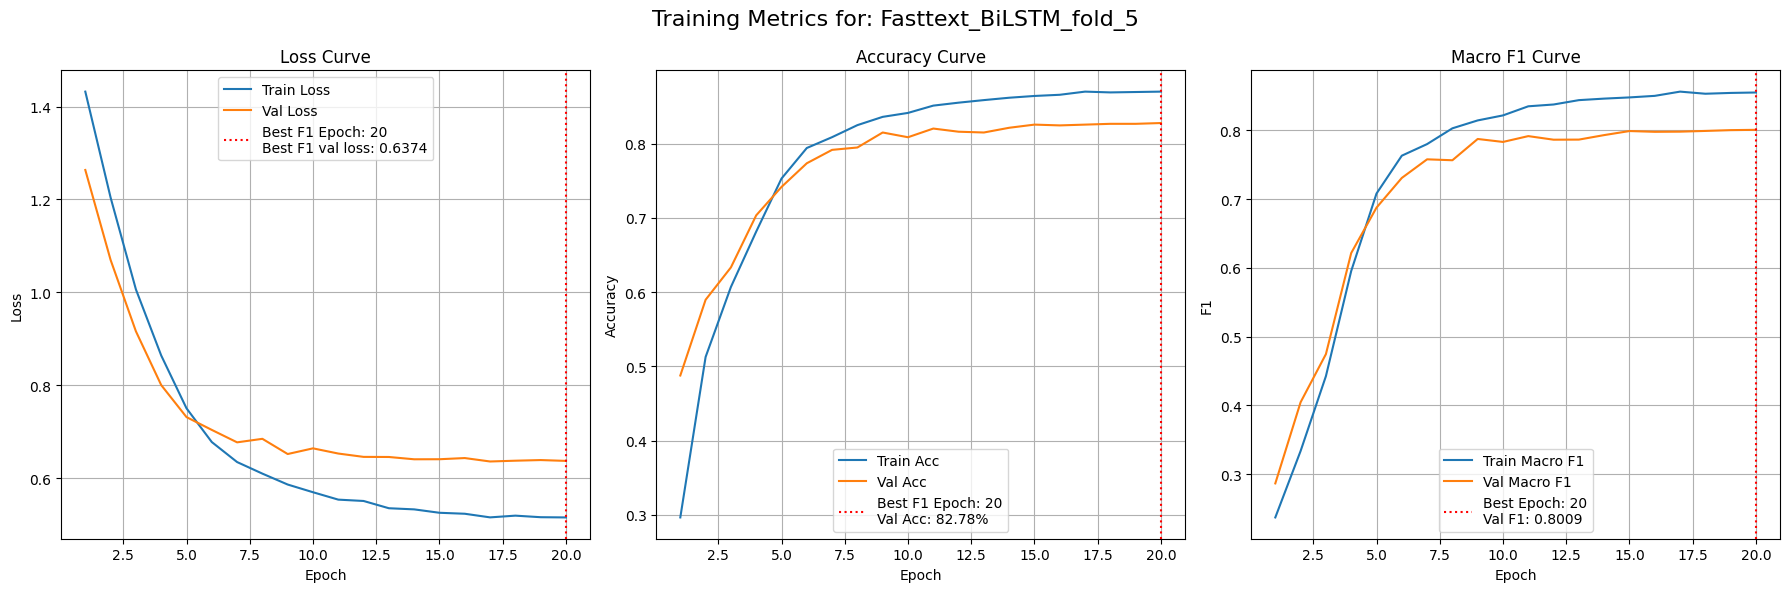

  Logging Fold 5 results under run_id: 8c0c4d84c1c74ea19ab54187c648f7db
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7557775533042774
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.88      0.93      0.90       378
LIGHT_PROFANITY       0.74      0.70      0.72       188
 HIGH_PROFANITY       0.79      0.73      0.76       120
       VIOLENCE       0.83      0.81      0.82       255

       accuracy                           0.83       941
      macro avg       0.81      0.79      0.80       941
   weighted avg       0.83      0.83      0.83       941

PR curve will be saved as Fasttext_BiLSTM_fold_5_PR.png


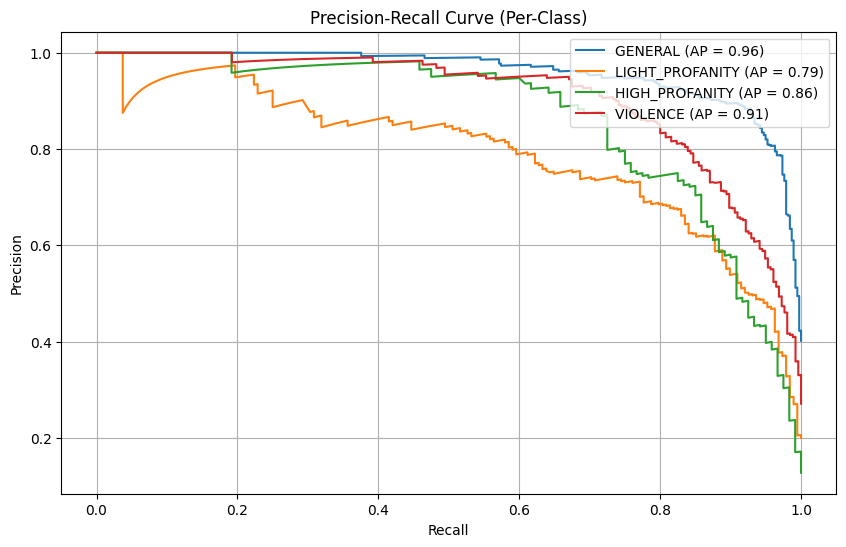

Confusion Matrix will be saved as Fasttext_BiLSTM_fold_5_cm.png


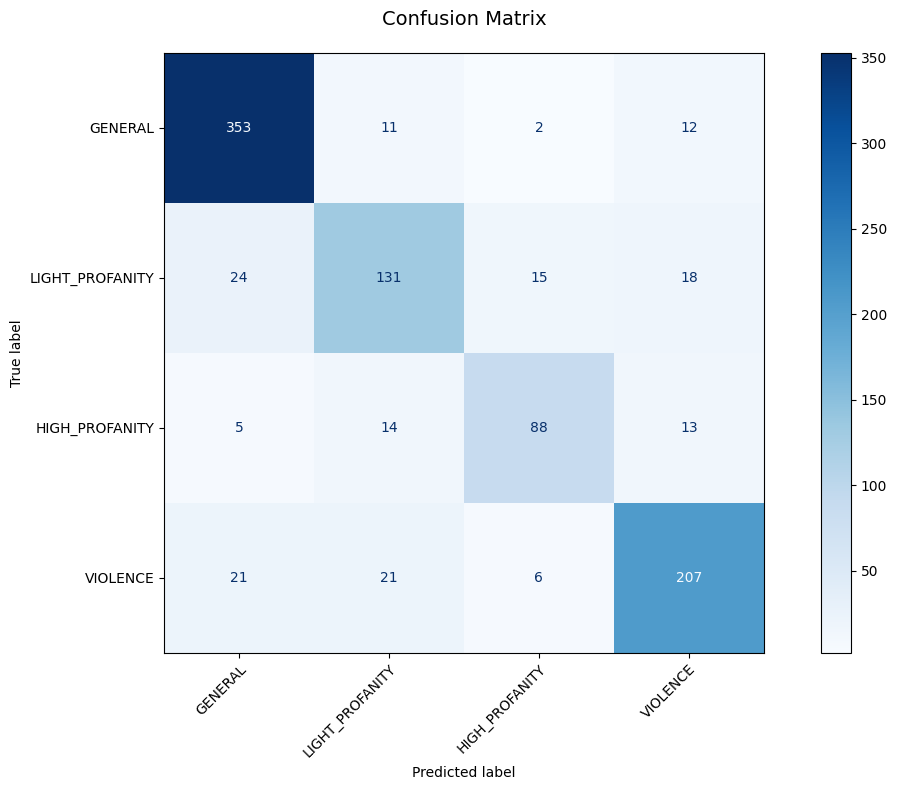

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/8c0c4d84c1c74ea19ab54187c648f7db
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for Fasttext_BiLSTM across 5 folds...
Overall Results for Fasttext_BiLSTM:
  Avg Accuracy: 0.8472
  Avg Macro F1: 0.8278
  Avg Macro precision: 0.8359
  Avg Macro recall: 0.8218
  Avg Weighted F1: 0.8455
  Avg MCC: 0.7837

Performing Overall Out-of-Fold Evaluation for Fasttext_BiLSTM...
Overall Out-of-Fold Classification Report for Fasttext_BiLSTM:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.94      0.90      1893
LIGHT_PROFANITY       0.80      0.73      0.76       938
 HIGH_PROFANITY       0.81      0.80      0.80       601
       VIOLENCE       0.87      0.82      0.84      1275

       accuracy                           0.85      4707
      macro avg       0.84   

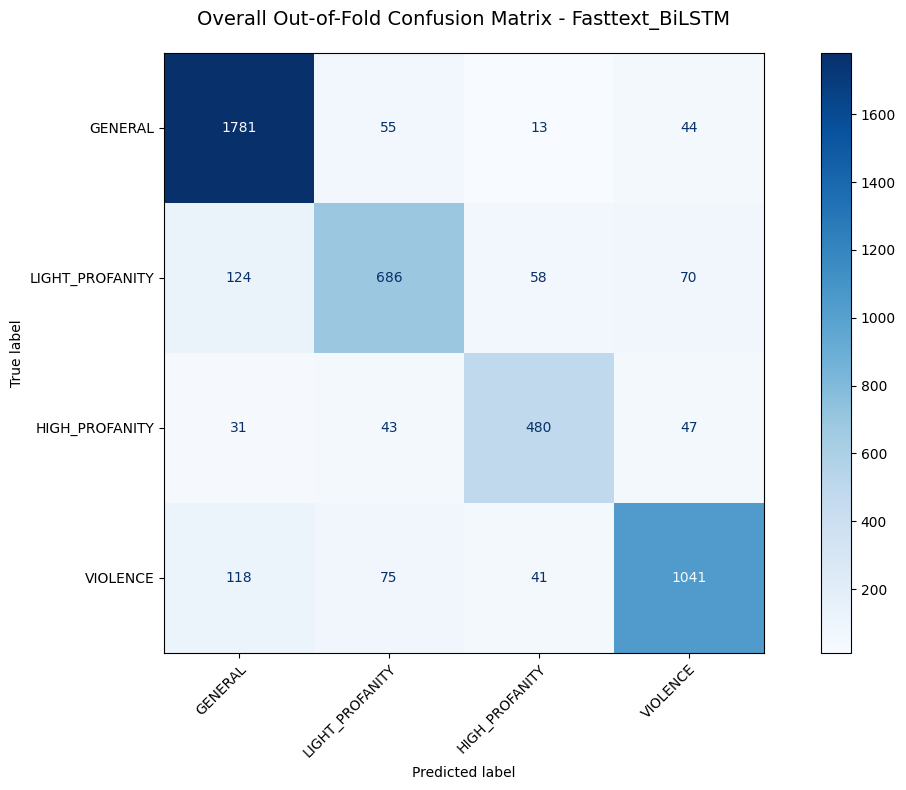

🏃 View run Fasttext_BiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/22b919899af049498a78e7c0f9c37aae
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [18]:
BiLSTM_cv_outputs = run_cross_validation(architectures_to_test[1], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

## DNN cross validation


Starting Cross-Validation for: Fasttext_DNN
  Applying dataset wrapper: DNNModifiedDataset
Epoch 1/60 | Train Loss: 1.2501 | Val Loss: 1.0372 | Train F1: 0.3548 | Val F1: 0.5112
Epoch 2/60 | Train Loss: 1.0444 | Val Loss: 0.8820 | Train F1: 0.4594 | Val F1: 0.5632
Epoch 3/60 | Train Loss: 0.9338 | Val Loss: 0.7755 | Train F1: 0.5127 | Val F1: 0.6080
Epoch 4/60 | Train Loss: 0.8797 | Val Loss: 0.7139 | Train F1: 0.5467 | Val F1: 0.6823
Epoch 5/60 | Train Loss: 0.8454 | Val Loss: 0.6810 | Train F1: 0.6006 | Val F1: 0.7236
Epoch 6/60 | Train Loss: 0.8108 | Val Loss: 0.6529 | Train F1: 0.6251 | Val F1: 0.7502
Epoch 7/60 | Train Loss: 0.7865 | Val Loss: 0.6164 | Train F1: 0.6566 | Val F1: 0.7714
Epoch 8/60 | Train Loss: 0.7659 | Val Loss: 0.6010 | Train F1: 0.6581 | Val F1: 0.7878
Epoch 9/60 | Train Loss: 0.7239 | Val Loss: 0.5746 | Train F1: 0.6870 | Val F1: 0.7945
Epoch 10/60 | Train Loss: 0.7220 | Val Loss: 0.5493 | Train F1: 0.6973 | Val F1: 0.7990
Epoch 11/60 | Train Loss: 0.7189 | Va

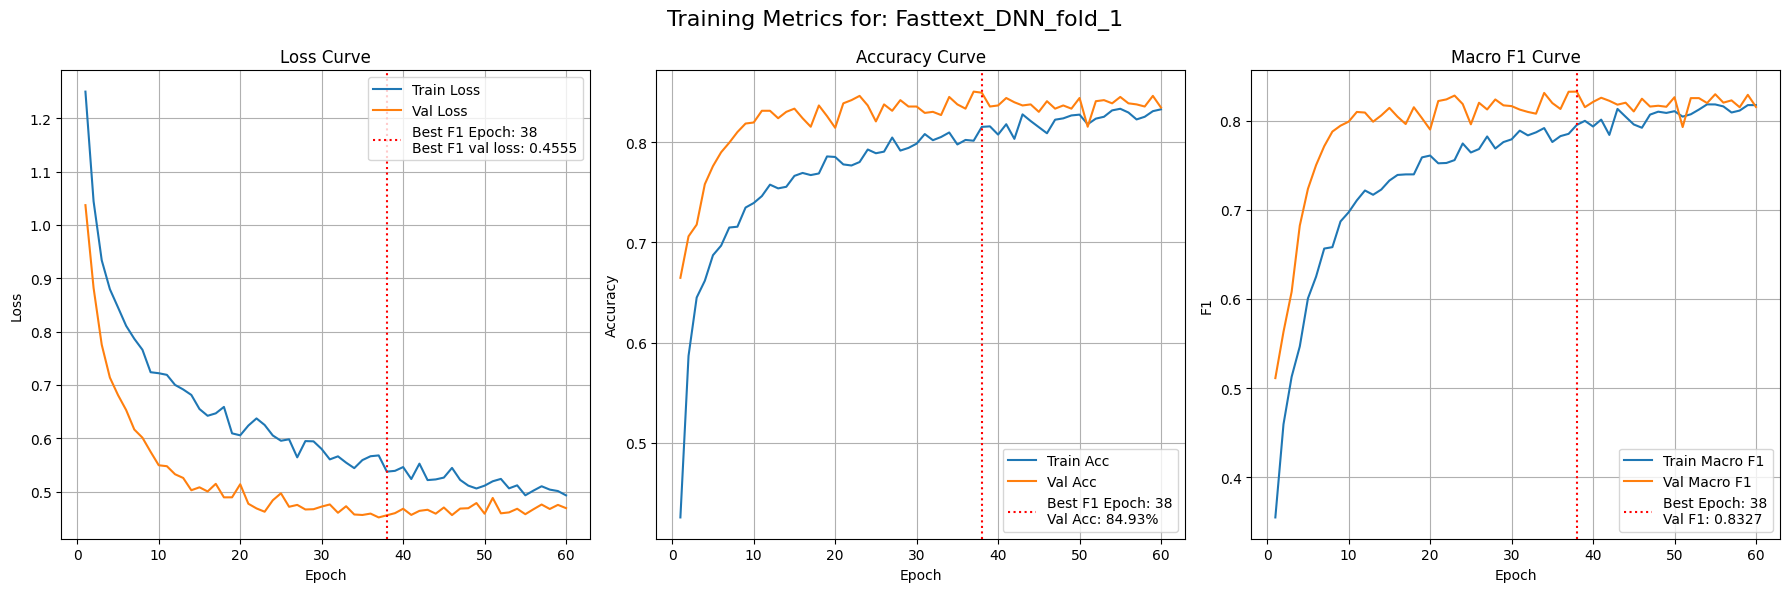

  Logging Fold 1 results under run_id: 0e05de7cc3a346ceb2fa462959aa6155
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/Fasttext_DNN_fold_1_state_dict.pt
Matthews correlation coefficient: 0.7875287195785565
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.88      0.90      0.89       379
LIGHT_PROFANITY       0.83      0.72      0.77       188
 HIGH_PROFANITY       0.77      0.85      0.81       120
       VIOLENCE       0.85      0.86      0.86       255

       accuracy                           0.85       942
      macro avg       0.83      0.83      0.83       942
   weighted avg       0.85      0.85      0.85       942

PR curve will be saved as Fasttext_DNN_fold_1_PR.png


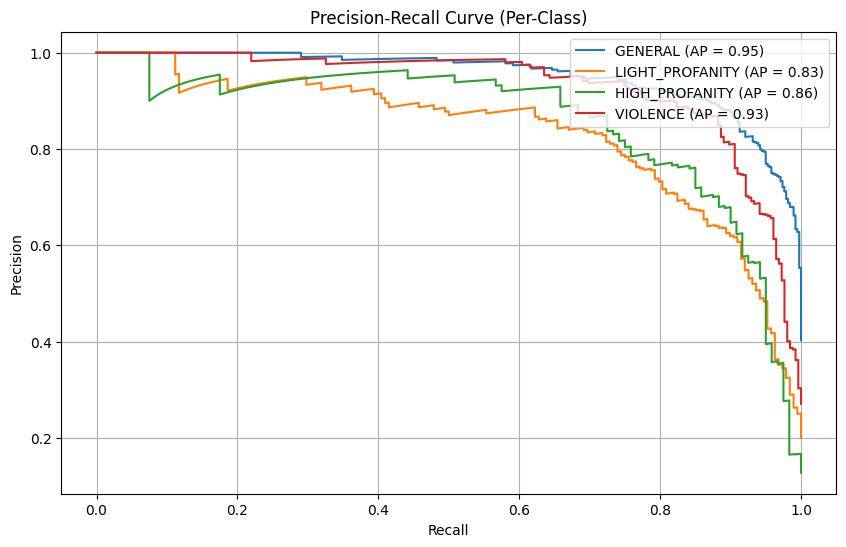

Confusion Matrix will be saved as Fasttext_DNN_fold_1_cm.png


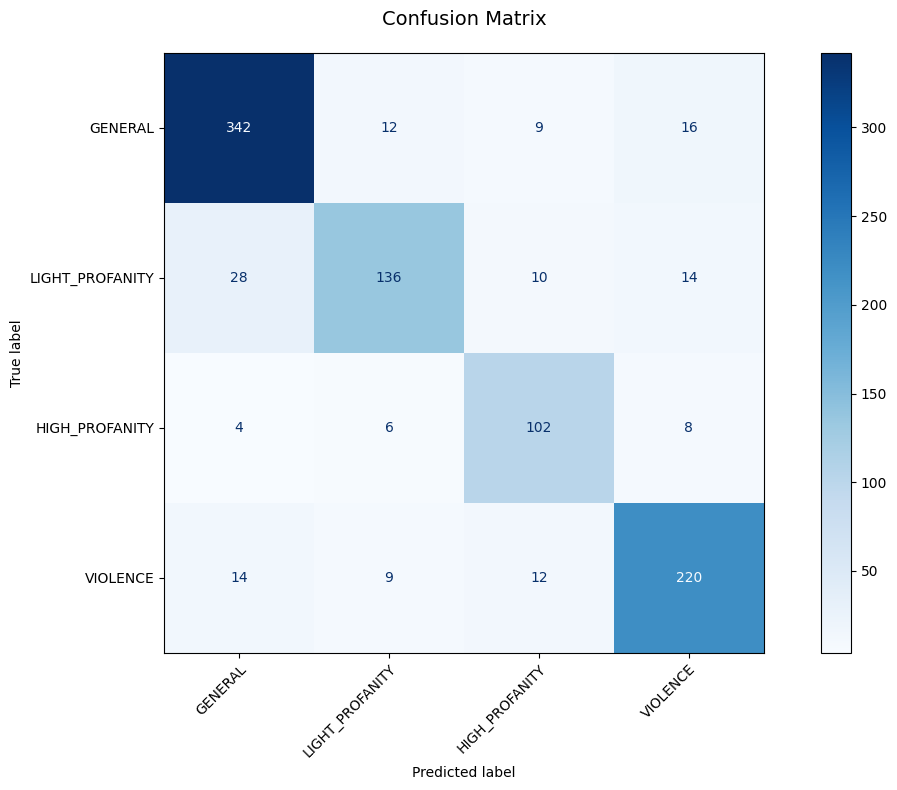

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/0e05de7cc3a346ceb2fa462959aa6155
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2666 | Val Loss: 1.0176 | Train F1: 0.3706 | Val F1: 0.6039
Epoch 2/60 | Train Loss: 1.0311 | Val Loss: 0.8646 | Train F1: 0.4917 | Val F1: 0.6437
Epoch 3/60 | Train Loss: 0.9354 | Val Loss: 0.7720 | Train F1: 0.5401 | Val F1: 0.6969
Epoch 4/60 | Train Loss: 0.8760 | Val Loss: 0.7081 | Train F1: 0.5793 | Val F1: 0.7029
Epoch 5/60 | Train Loss: 0.8163 | Val Loss: 0.6632 | Train F1: 0.6367 | Val F1: 0.7510
Epoch 6/60 | Train Loss: 0.7852 | Val Loss: 0.6208 | Train F1: 0.6641 | Val F1: 0.7672
Epoch 7/60 | Train Loss: 0.7727 | Val Loss: 0.5951 | Train F1: 0.6733 | Val F1: 0.7616
Epoch 8/60 | Train Loss: 0.7436 | Val Loss: 0.5733 | Train F1: 0.6938 | Val F1: 0.7714
Epoch 9/60 | Train Loss: 0.7466 | Val Loss: 0.576

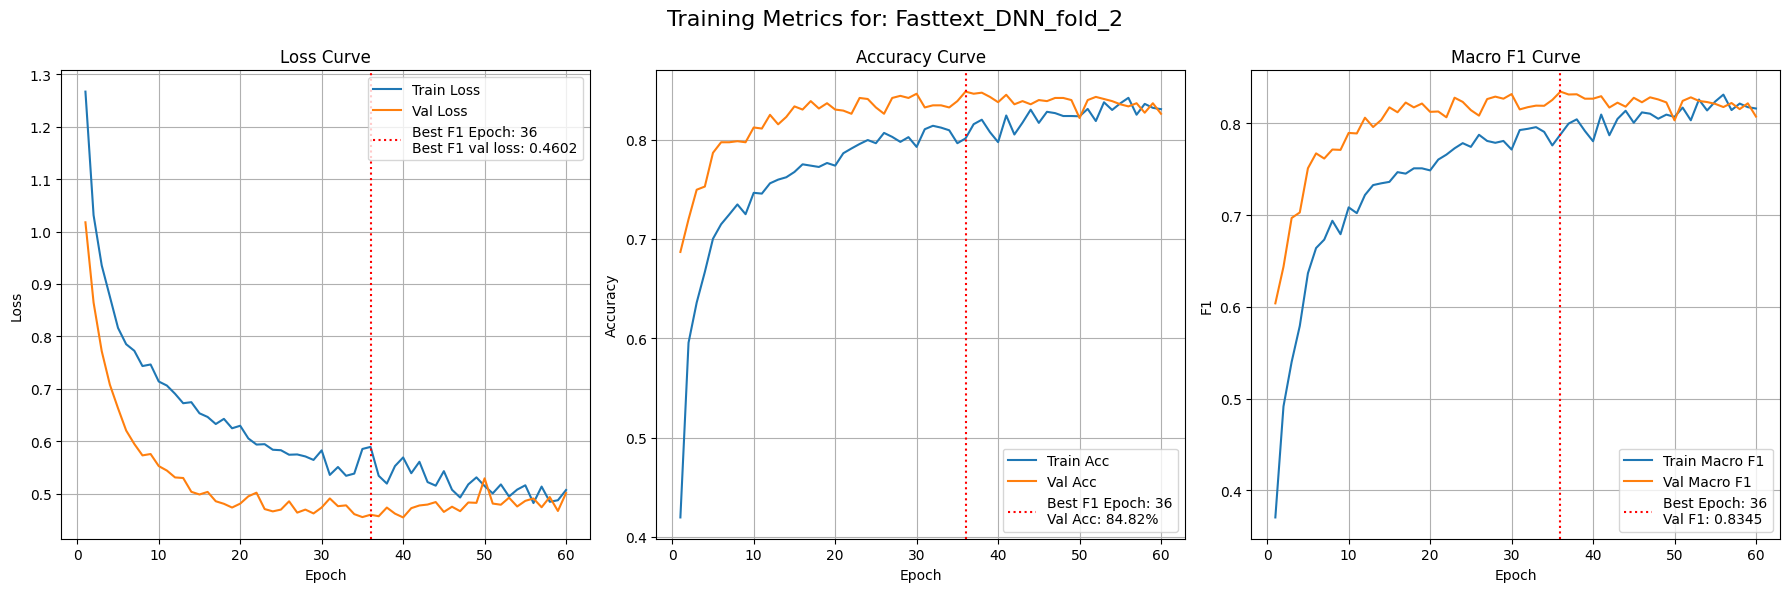

  Logging Fold 2 results under run_id: 9e46bb071c6345458ca31a565df1b8c0
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/Fasttext_DNN_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7849830154109081
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.93      0.88       379
LIGHT_PROFANITY       0.78      0.74      0.76       187
 HIGH_PROFANITY       0.87      0.79      0.83       121
       VIOLENCE       0.91      0.83      0.86       255

       accuracy                           0.85       942
      macro avg       0.85      0.82      0.83       942
   weighted avg       0.85      0.85      0.85       942

PR curve will be saved as Fasttext_DNN_fold_2_PR.png


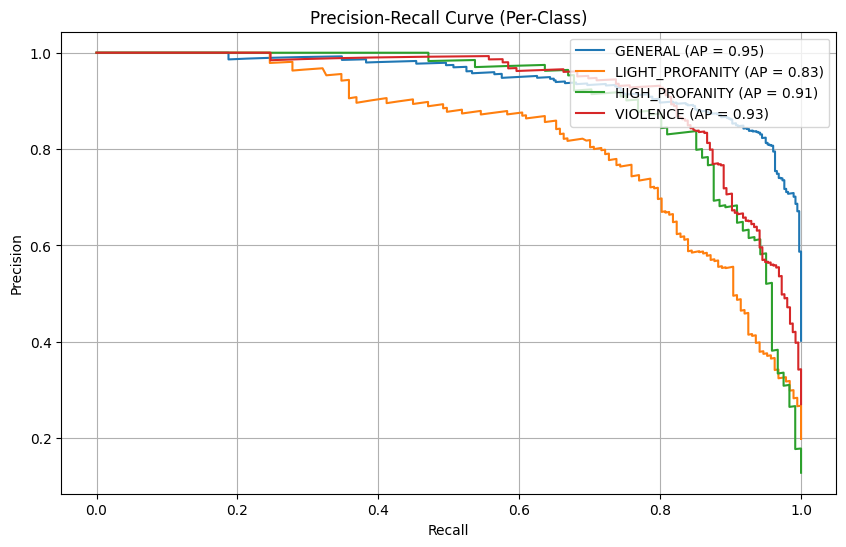

Confusion Matrix will be saved as Fasttext_DNN_fold_2_cm.png


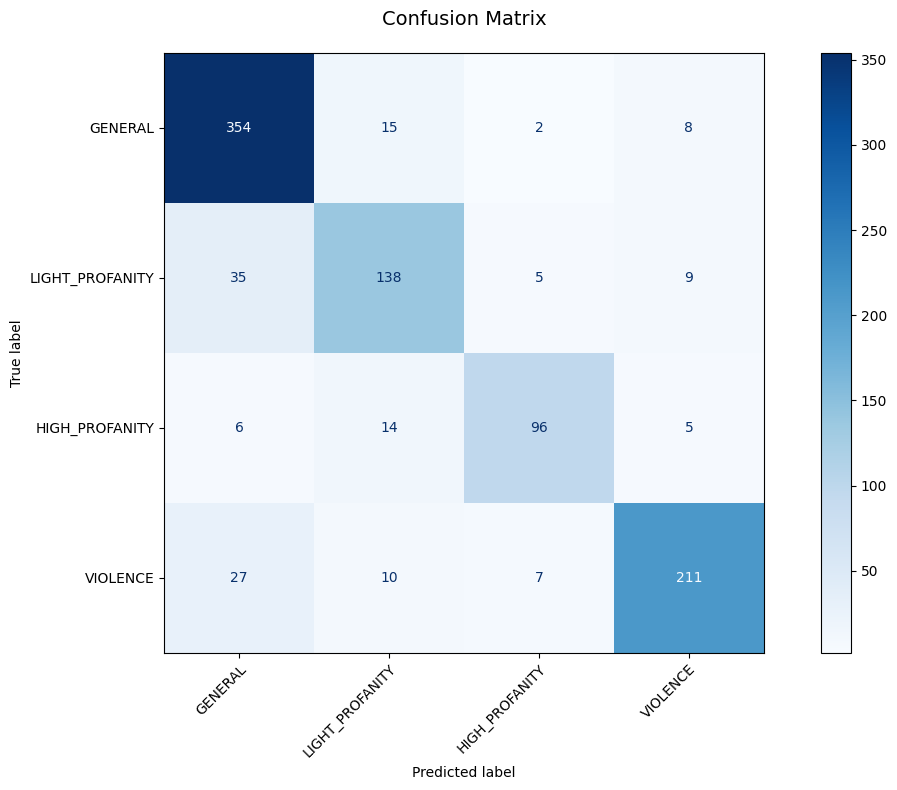

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/9e46bb071c6345458ca31a565df1b8c0
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2822 | Val Loss: 1.0875 | Train F1: 0.3642 | Val F1: 0.5358
Epoch 2/60 | Train Loss: 1.0630 | Val Loss: 0.9050 | Train F1: 0.4711 | Val F1: 0.5848
Epoch 3/60 | Train Loss: 0.9331 | Val Loss: 0.8094 | Train F1: 0.5510 | Val F1: 0.6480
Epoch 4/60 | Train Loss: 0.8775 | Val Loss: 0.7746 | Train F1: 0.5955 | Val F1: 0.6970
Epoch 5/60 | Train Loss: 0.8343 | Val Loss: 0.7273 | Train F1: 0.6332 | Val F1: 0.7172
Epoch 6/60 | Train Loss: 0.7835 | Val Loss: 0.6738 | Train F1: 0.6513 | Val F1: 0.7174
Epoch 7/60 | Train Loss: 0.7699 | Val Loss: 0.6647 | Train F1: 0.6634 | Val F1: 0.7145
Epoch 8/60 | Train Loss: 0.7276 | Val Loss: 0.6400 | Train F1: 0.6938 | Val F1: 0.7294
Epoch 9/60 | Train Loss: 0.7371 | Val Loss: 0.603

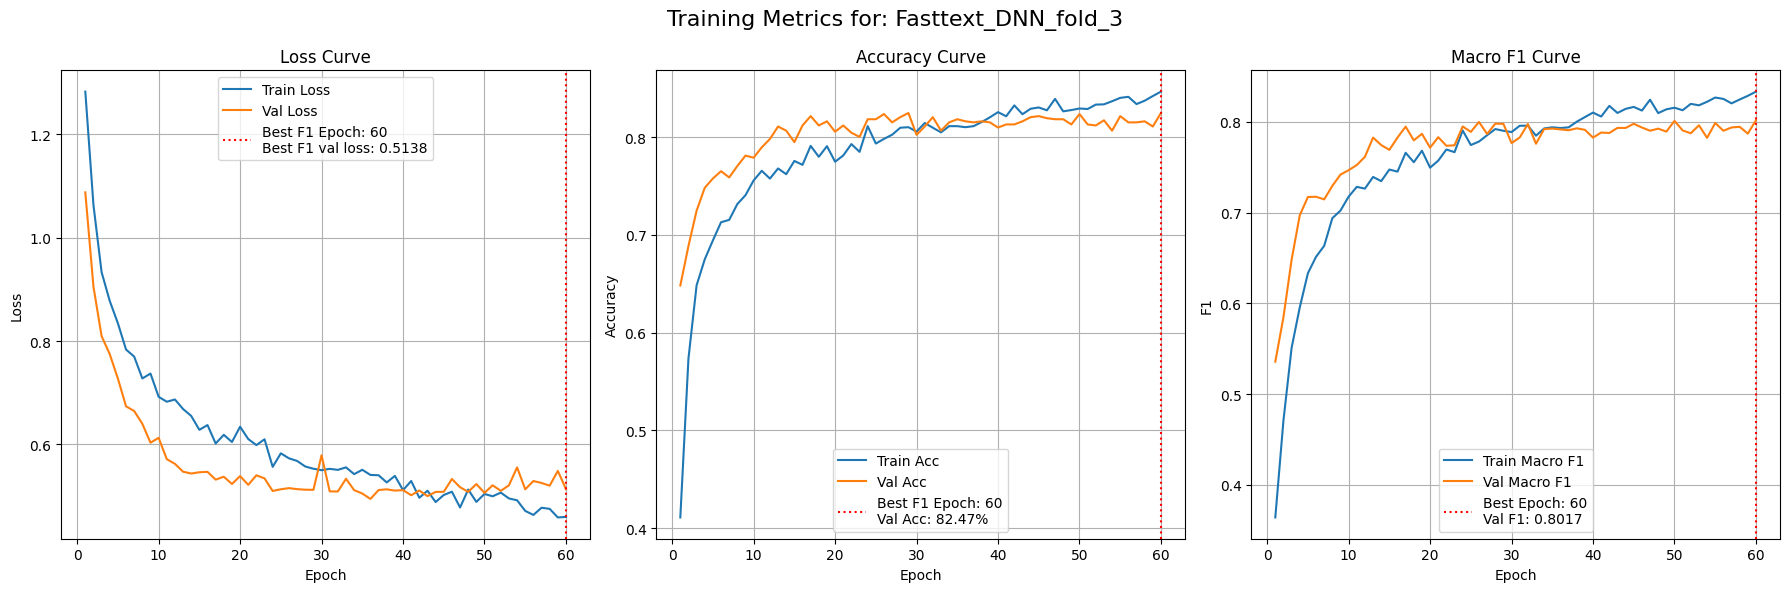

  Logging Fold 3 results under run_id: 139145ec857b4b9592524531b59ca440
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/Fasttext_DNN_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7510629604502062
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.93      0.88       379
LIGHT_PROFANITY       0.78      0.70      0.74       187
 HIGH_PROFANITY       0.79      0.74      0.76       120
       VIOLENCE       0.85      0.80      0.82       255

       accuracy                           0.82       941
      macro avg       0.81      0.79      0.80       941
   weighted avg       0.82      0.82      0.82       941

PR curve will be saved as Fasttext_DNN_fold_3_PR.png


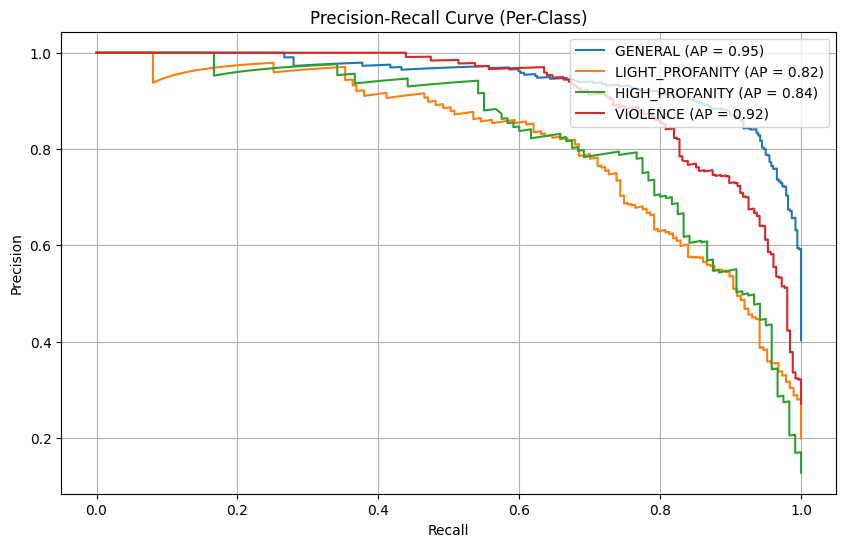

Confusion Matrix will be saved as Fasttext_DNN_fold_3_cm.png


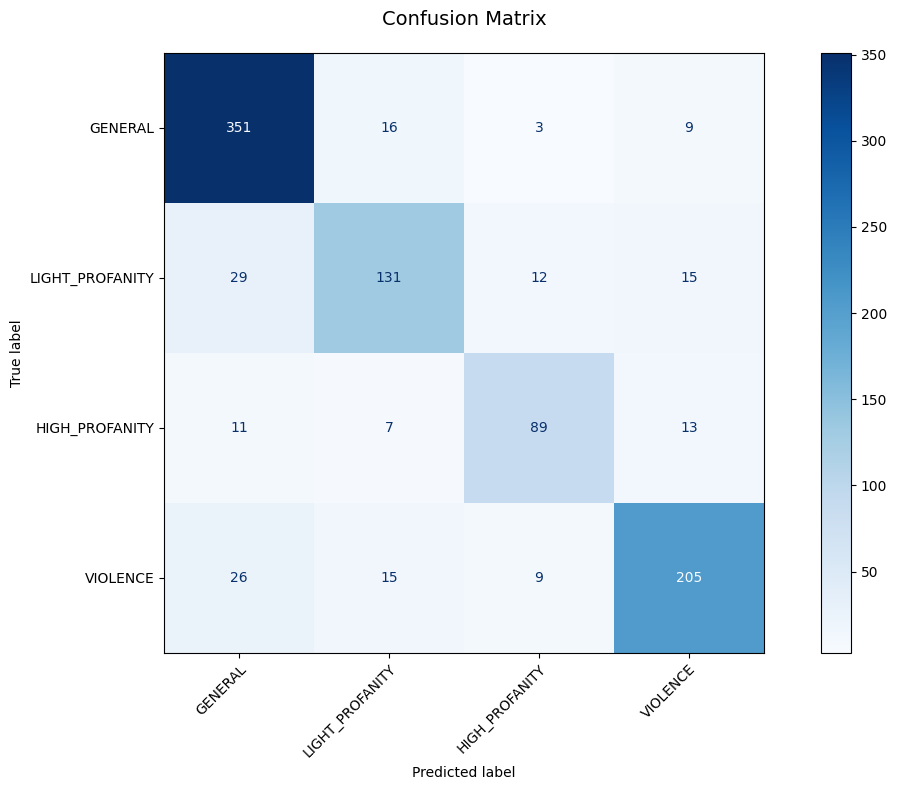

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/139145ec857b4b9592524531b59ca440
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2699 | Val Loss: 1.0726 | Train F1: 0.3774 | Val F1: 0.6022
Epoch 2/60 | Train Loss: 1.0379 | Val Loss: 0.8672 | Train F1: 0.5156 | Val F1: 0.6663
Epoch 3/60 | Train Loss: 0.9327 | Val Loss: 0.8110 | Train F1: 0.5489 | Val F1: 0.6881
Epoch 4/60 | Train Loss: 0.8637 | Val Loss: 0.7407 | Train F1: 0.6105 | Val F1: 0.7158
Epoch 5/60 | Train Loss: 0.8169 | Val Loss: 0.7048 | Train F1: 0.6438 | Val F1: 0.7488
Epoch 6/60 | Train Loss: 0.7961 | Val Loss: 0.6394 | Train F1: 0.6573 | Val F1: 0.7667
Epoch 7/60 | Train Loss: 0.7764 | Val Loss: 0.6089 | Train F1: 0.6681 | Val F1: 0.7710
Epoch 8/60 | Train Loss: 0.7418 | Val Loss: 0.6211 | Train F1: 0.6867 | Val F1: 0.7741
Epoch 9/60 | Train Loss: 0.7165 | Val Loss: 0.574

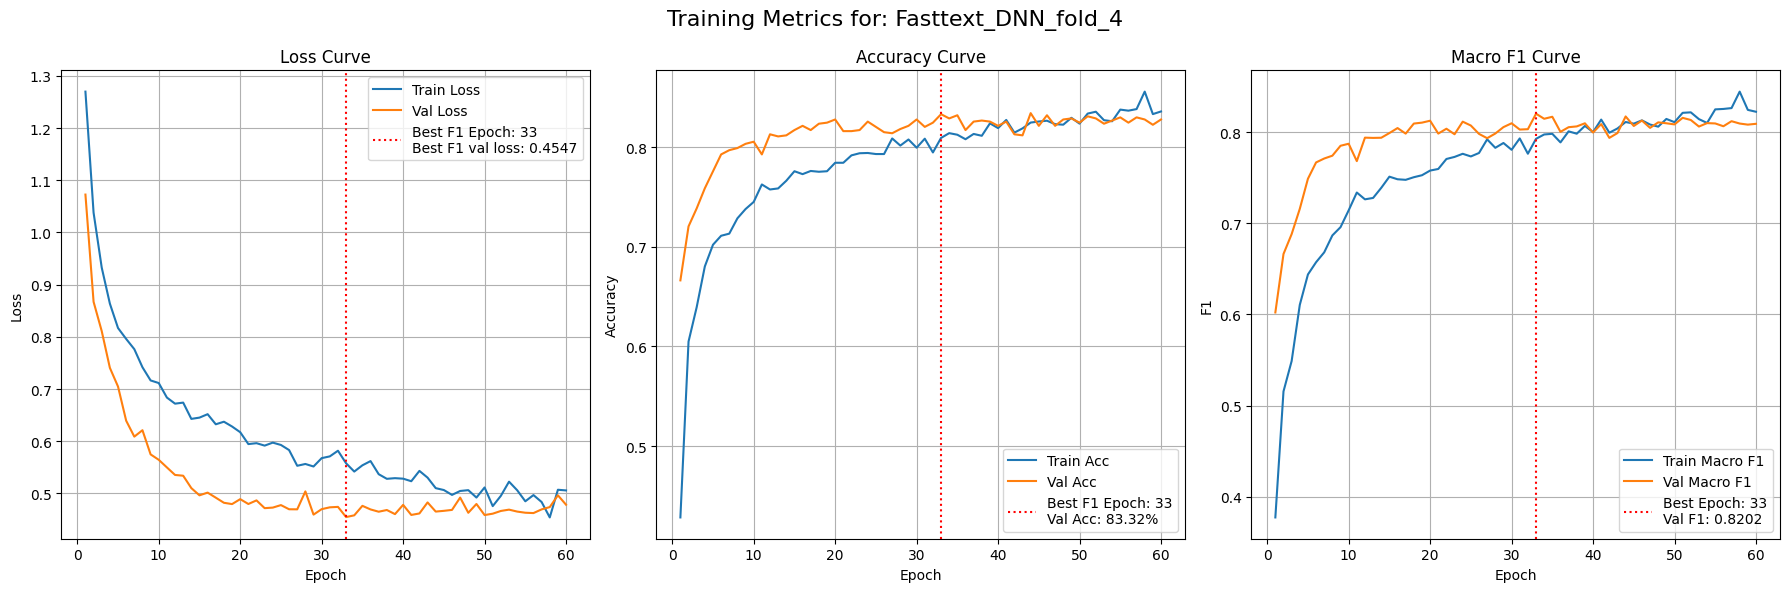

  Logging Fold 4 results under run_id: 9327ea3373234e4db5be81da15fa4184
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/Fasttext_DNN_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7643539306109842
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.88      0.87       378
LIGHT_PROFANITY       0.74      0.78      0.76       188
 HIGH_PROFANITY       0.84      0.77      0.80       120
       VIOLENCE       0.86      0.84      0.85       255

       accuracy                           0.83       941
      macro avg       0.83      0.82      0.82       941
   weighted avg       0.83      0.83      0.83       941

PR curve will be saved as Fasttext_DNN_fold_4_PR.png


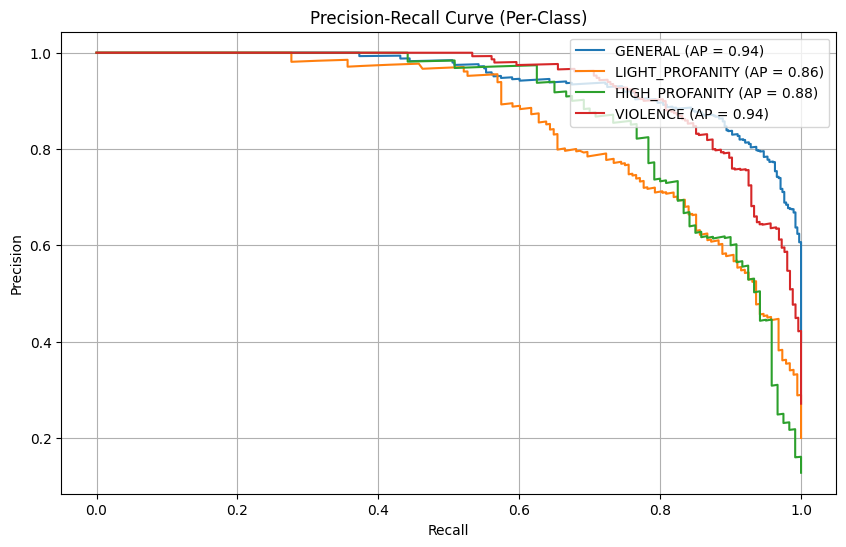

Confusion Matrix will be saved as Fasttext_DNN_fold_4_cm.png


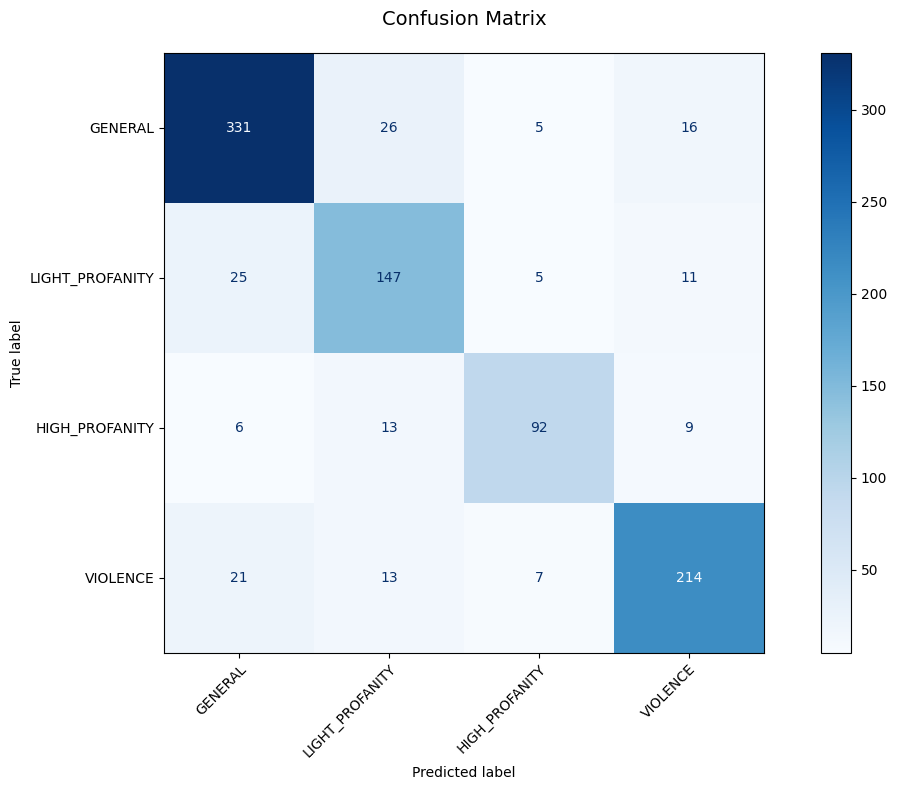

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/9327ea3373234e4db5be81da15fa4184
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2523 | Val Loss: 1.0657 | Train F1: 0.3269 | Val F1: 0.4789
Epoch 2/60 | Train Loss: 1.0481 | Val Loss: 0.9209 | Train F1: 0.4683 | Val F1: 0.6092
Epoch 3/60 | Train Loss: 0.9250 | Val Loss: 0.8197 | Train F1: 0.5632 | Val F1: 0.6484
Epoch 4/60 | Train Loss: 0.8702 | Val Loss: 0.7573 | Train F1: 0.5772 | Val F1: 0.6887
Epoch 5/60 | Train Loss: 0.8336 | Val Loss: 0.7061 | Train F1: 0.6298 | Val F1: 0.7020
Epoch 6/60 | Train Loss: 0.7965 | Val Loss: 0.6890 | Train F1: 0.6598 | Val F1: 0.7235
Epoch 7/60 | Train Loss: 0.7535 | Val Loss: 0.6782 | Train F1: 0.6682 | Val F1: 0.7064
Epoch 8/60 | Train Loss: 0.7250 | Val Loss: 0.6260 | Train F1: 0.6938 | Val F1: 0.7316
Epoch 9/60 | Train Loss: 0.6991 | Val Loss: 0.620

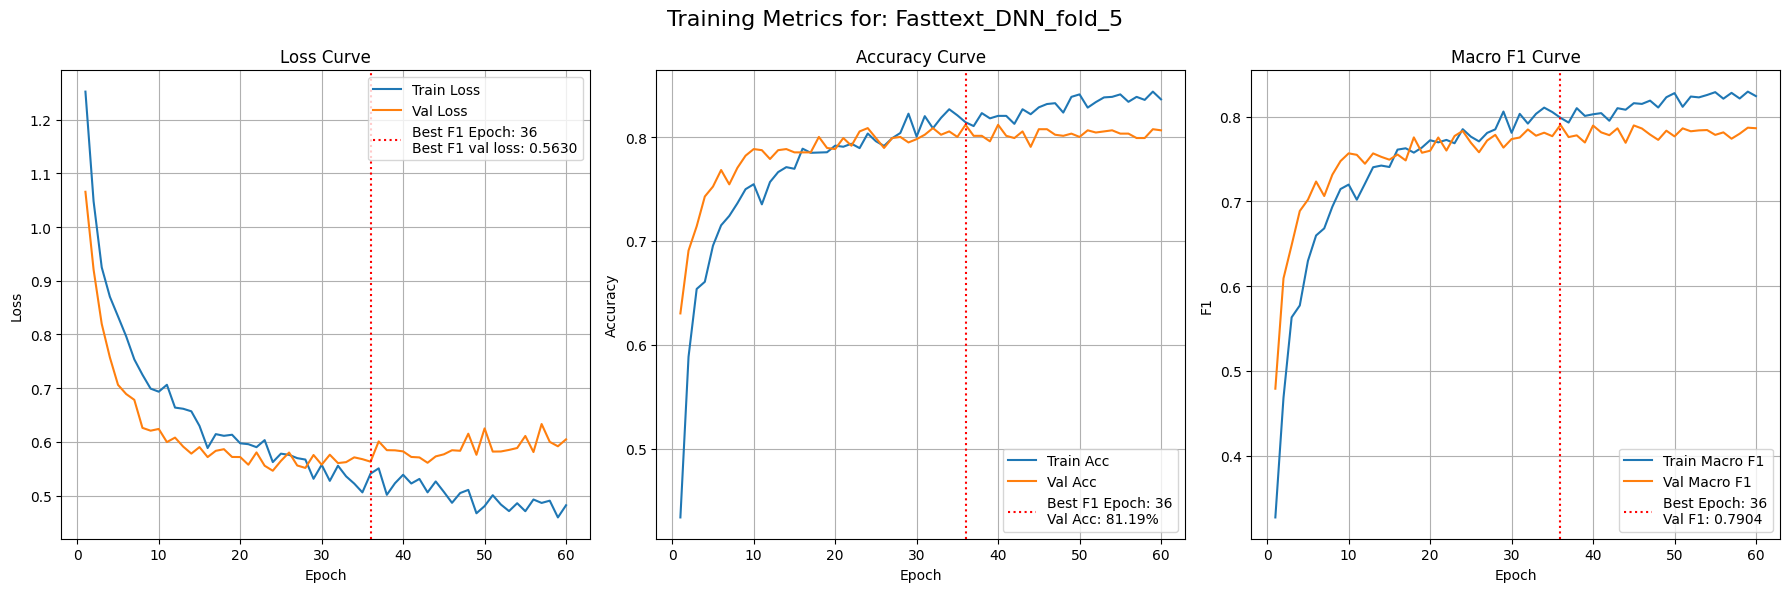

  Logging Fold 5 results under run_id: f7f7ef15f3b042618a1fc791038c9a24
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/Fasttext_DNN_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7328374526973752
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.90      0.87       378
LIGHT_PROFANITY       0.76      0.66      0.71       188
 HIGH_PROFANITY       0.81      0.73      0.77       120
       VIOLENCE       0.79      0.82      0.81       255

       accuracy                           0.81       941
      macro avg       0.80      0.78      0.79       941
   weighted avg       0.81      0.81      0.81       941

PR curve will be saved as Fasttext_DNN_fold_5_PR.png


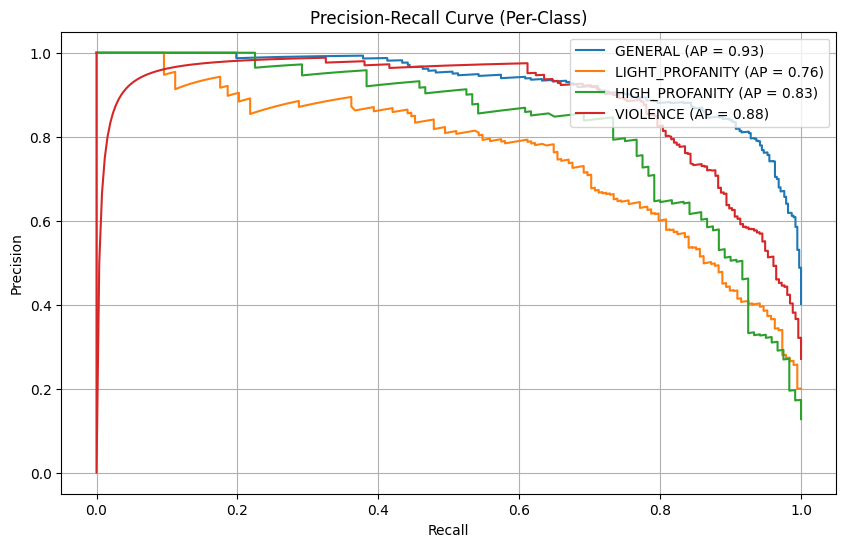

Confusion Matrix will be saved as Fasttext_DNN_fold_5_cm.png


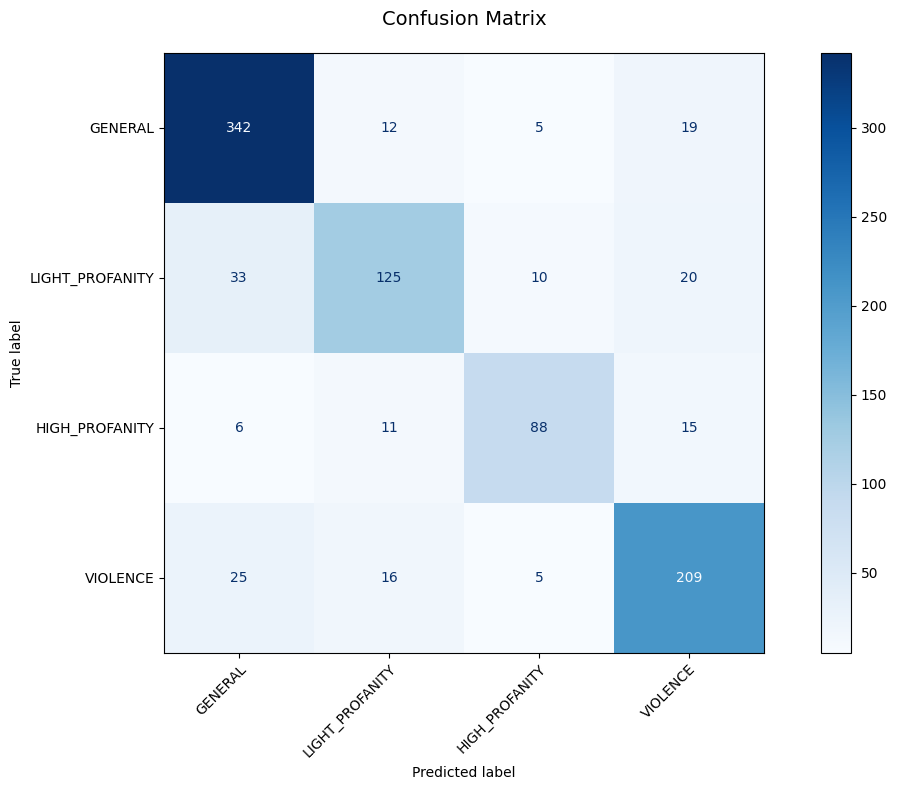

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/f7f7ef15f3b042618a1fc791038c9a24
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for Fasttext_DNN across 5 folds...
Overall Results for Fasttext_DNN:
  Avg Accuracy: 0.8334
  Avg Macro F1: 0.8159
  Avg Macro precision: 0.8250
  Avg Macro recall: 0.8095
  Avg Weighted F1: 0.8321
  Avg MCC: 0.7642

Performing Overall Out-of-Fold Evaluation for Fasttext_DNN...
Overall Out-of-Fold Classification Report for Fasttext_DNN:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.91      0.88      1893
LIGHT_PROFANITY       0.78      0.72      0.75       938
 HIGH_PROFANITY       0.82      0.78      0.80       601
       VIOLENCE       0.85      0.83      0.84      1275

       accuracy                           0.83      4707
      macro avg       0.82      0.81     

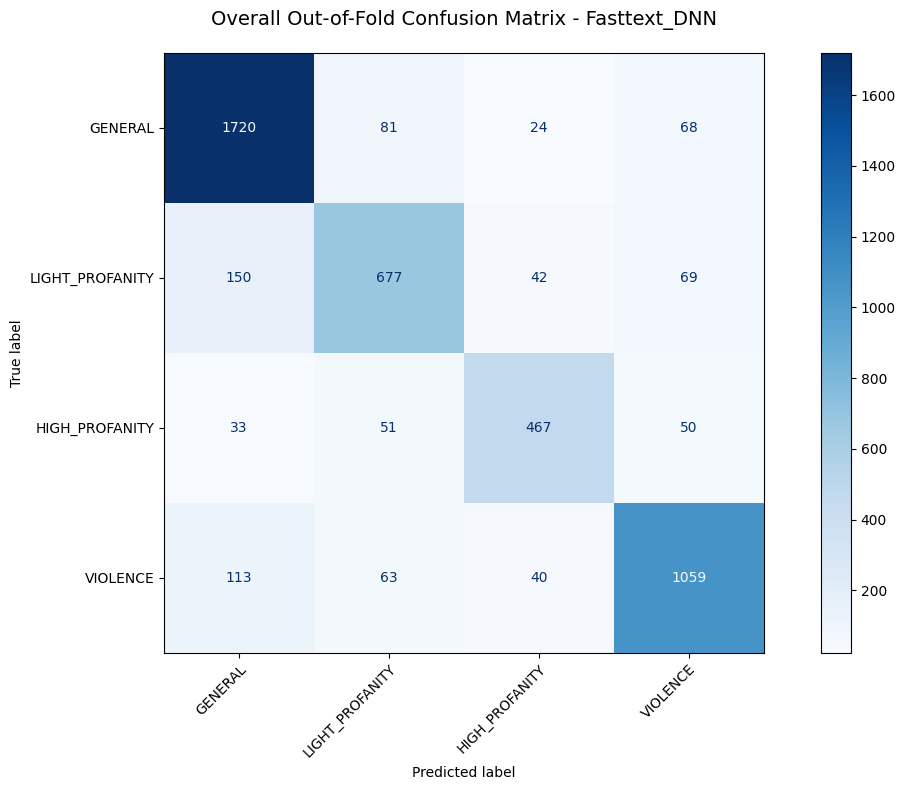

🏃 View run Fasttext_DNN at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/eb763a06085b4ca8961509417945f285
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [19]:
dnn_cv_outputs = run_cross_validation(architectures_to_test[2], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

## Residual BiLSTM cross validation


Starting Cross-Validation for: Fasttext_BiLSTM_residual
Epoch 1/20 | Train Loss: 1.3444 | Val Loss: 1.2426 | Train F1: 0.2763 | Val F1: 0.2871
Epoch 2/20 | Train Loss: 1.1838 | Val Loss: 1.0558 | Train F1: 0.3419 | Val F1: 0.3749
Epoch 3/20 | Train Loss: 1.0047 | Val Loss: 0.8670 | Train F1: 0.4806 | Val F1: 0.5489
Epoch 4/20 | Train Loss: 0.8479 | Val Loss: 0.7533 | Train F1: 0.6219 | Val F1: 0.6641
Epoch 5/20 | Train Loss: 0.7478 | Val Loss: 0.6783 | Train F1: 0.7022 | Val F1: 0.7485
Epoch 6/20 | Train Loss: 0.6804 | Val Loss: 0.6384 | Train F1: 0.7497 | Val F1: 0.7676
Epoch 7/20 | Train Loss: 0.6320 | Val Loss: 0.6196 | Train F1: 0.7836 | Val F1: 0.7935
Epoch 8/20 | Train Loss: 0.6000 | Val Loss: 0.6036 | Train F1: 0.8068 | Val F1: 0.7982
Epoch 9/20 | Train Loss: 0.5804 | Val Loss: 0.6031 | Train F1: 0.8134 | Val F1: 0.8001
Epoch 10/20 | Train Loss: 0.5552 | Val Loss: 0.6055 | Train F1: 0.8334 | Val F1: 0.7971
Epoch 11/20 | Train Loss: 0.5393 | Val Loss: 0.6077 | Train F1: 0.8461 |

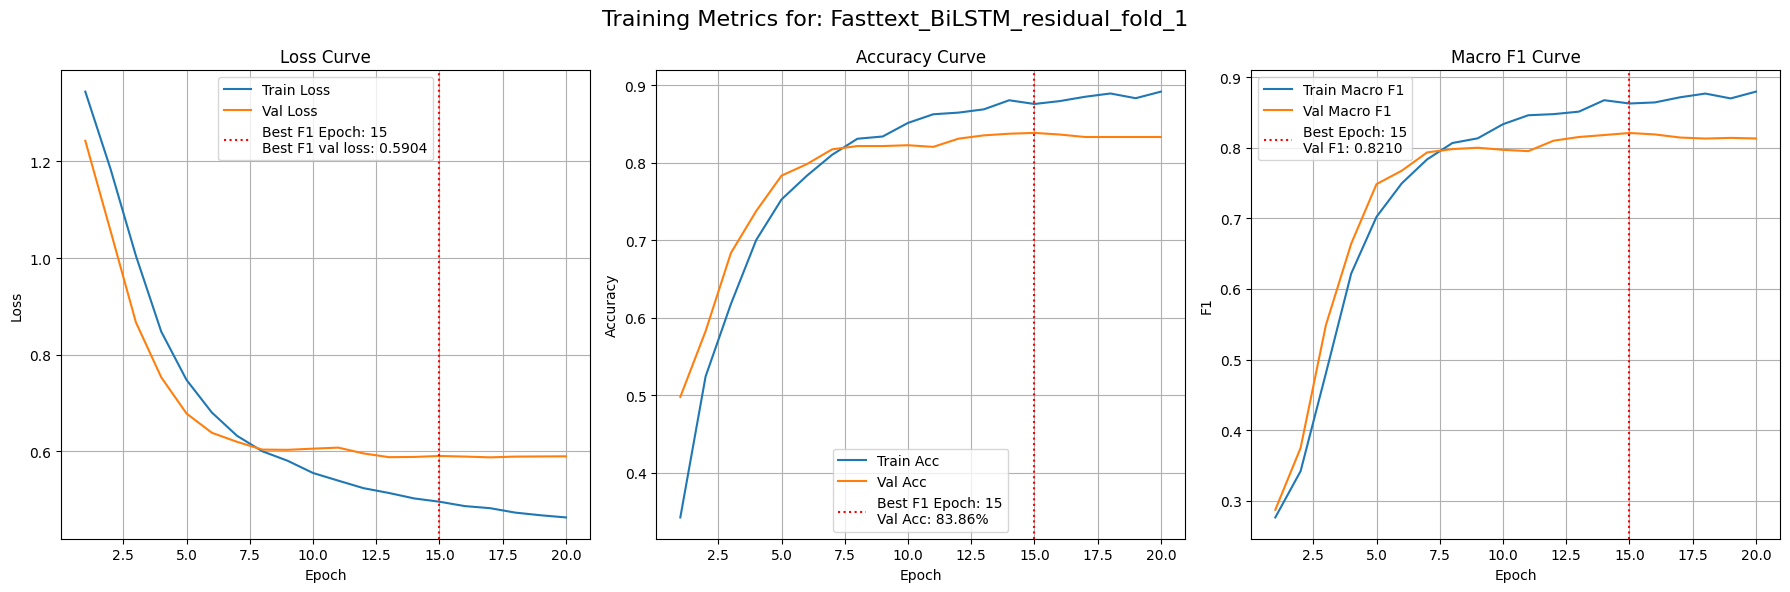

  Logging Fold 1 results under run_id: 0bcac90b422949d6bbc05075afde9058
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_residual_fold_1_state_dict.pt
Matthews correlation coefficient: 0.7716190751935565
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.93      0.89       379
LIGHT_PROFANITY       0.76      0.74      0.75       188
 HIGH_PROFANITY       0.82      0.79      0.81       120
       VIOLENCE       0.88      0.80      0.84       255

       accuracy                           0.84       942
      macro avg       0.83      0.82      0.82       942
   weighted avg       0.84      0.84      0.84       942

PR curve will be saved as Fasttext_BiLSTM_residual_fold_1_PR.png


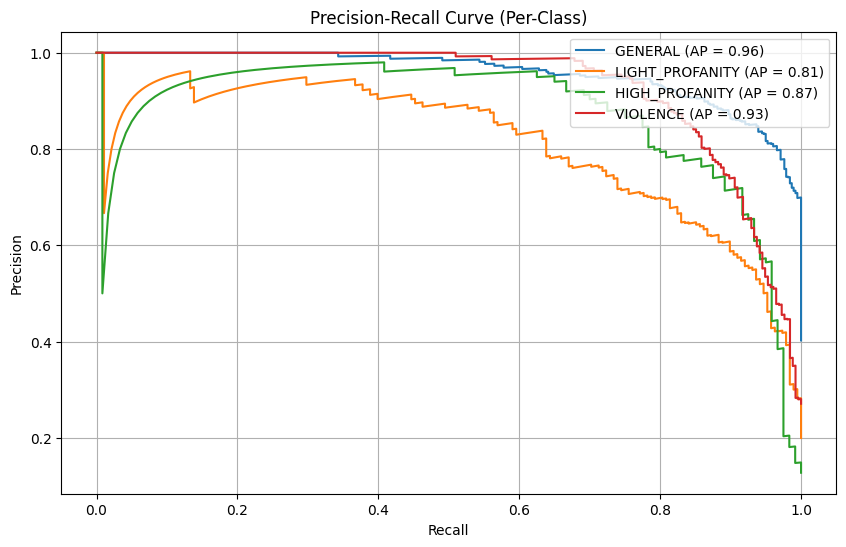

Confusion Matrix will be saved as Fasttext_BiLSTM_residual_fold_1_cm.png


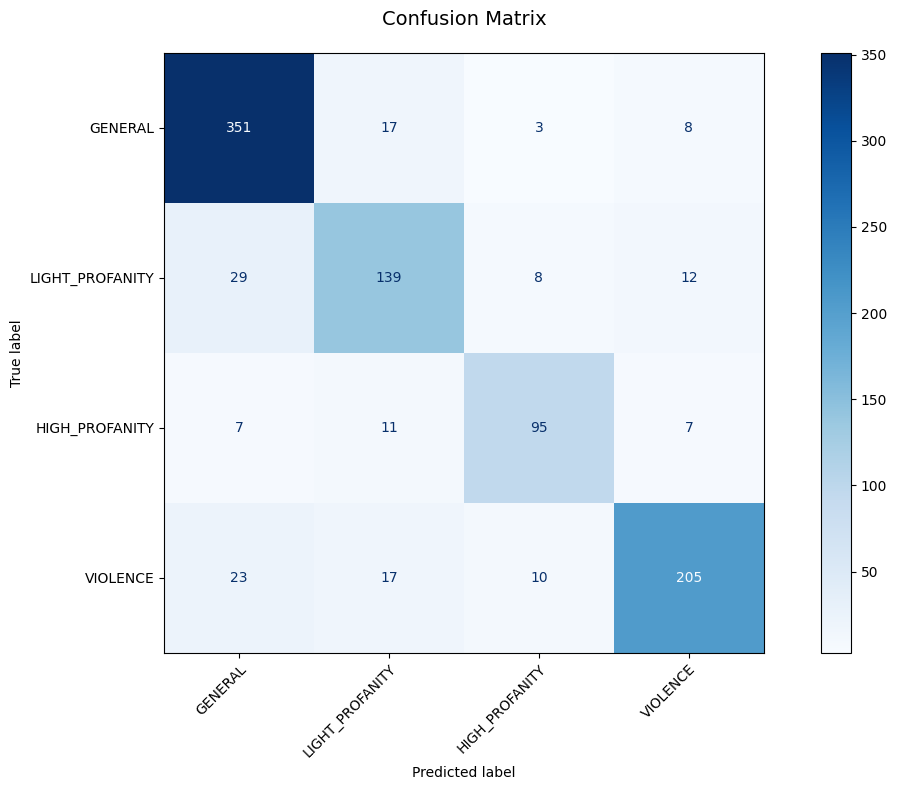

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/0bcac90b422949d6bbc05075afde9058
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3193 | Val Loss: 1.2387 | Train F1: 0.2855 | Val F1: 0.2979
Epoch 2/20 | Train Loss: 1.1715 | Val Loss: 1.0458 | Train F1: 0.3654 | Val F1: 0.3529
Epoch 3/20 | Train Loss: 1.0036 | Val Loss: 0.8787 | Train F1: 0.4593 | Val F1: 0.5411
Epoch 4/20 | Train Loss: 0.8589 | Val Loss: 0.7661 | Train F1: 0.5894 | Val F1: 0.6870
Epoch 5/20 | Train Loss: 0.7540 | Val Loss: 0.7009 | Train F1: 0.6889 | Val F1: 0.7526
Epoch 6/20 | Train Loss: 0.6911 | Val Loss: 0.6755 | Train F1: 0.7418 | Val F1: 0.7706
Epoch 7/20 | Train Loss: 0.6371 | Val Loss: 0.6620 | Train F1: 0.7722 | Val F1: 0.7806
Epoch 8/20 | Train Loss: 0.6018 | Val Loss: 0.6641 | Train F1: 0.7872 | Val F1: 0.7818
Epoch 9/20 | Train Loss: 0.5693 | Val Loss: 0.671

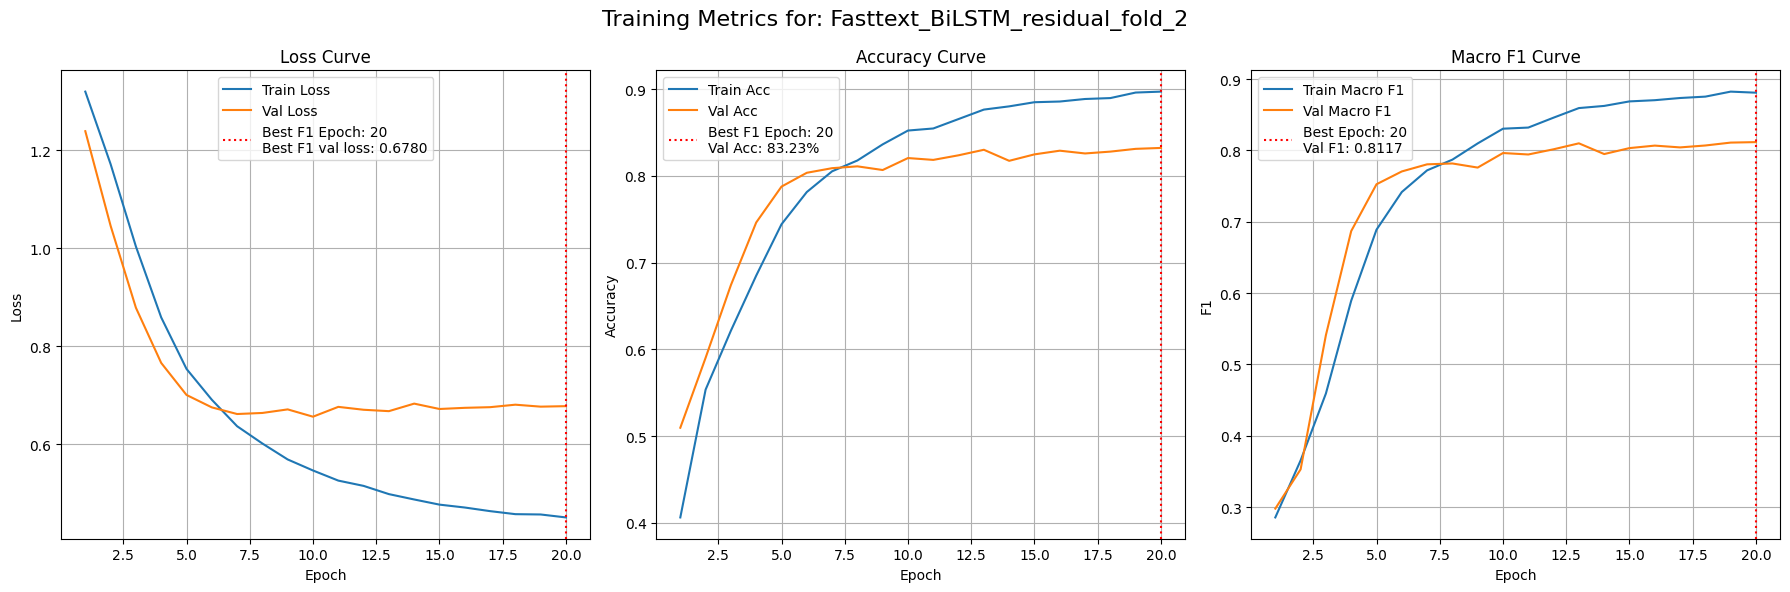

  Logging Fold 2 results under run_id: e2ca93fb203a4b51aef775141b89358a
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_residual_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7621034842827658
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.93      0.89       379
LIGHT_PROFANITY       0.77      0.70      0.73       187
 HIGH_PROFANITY       0.81      0.78      0.79       121
       VIOLENCE       0.85      0.82      0.83       255

       accuracy                           0.83       942
      macro avg       0.82      0.80      0.81       942
   weighted avg       0.83      0.83      0.83       942

PR curve will be saved as Fasttext_BiLSTM_residual_fold_2_PR.png


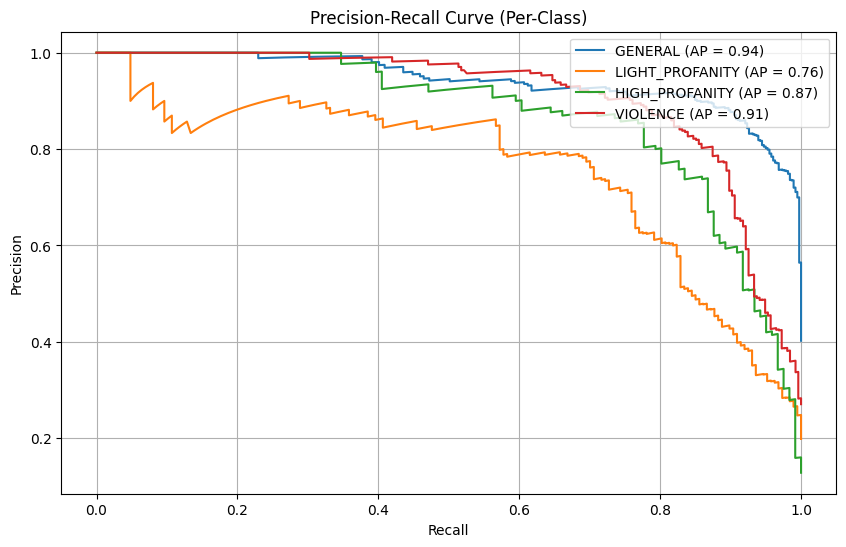

Confusion Matrix will be saved as Fasttext_BiLSTM_residual_fold_2_cm.png


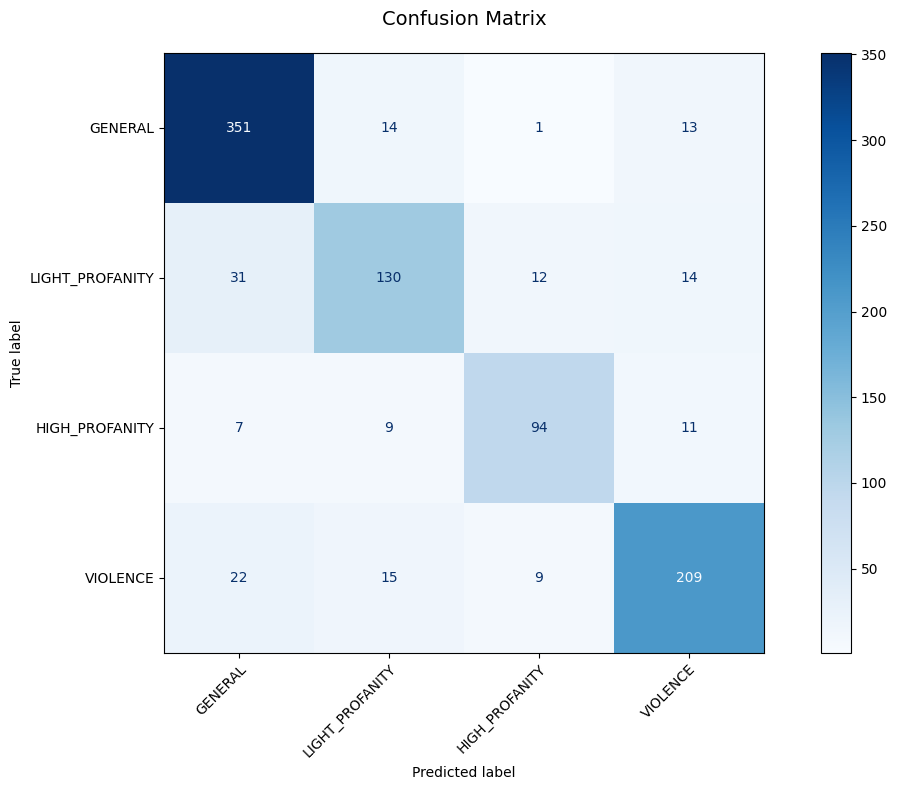

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/e2ca93fb203a4b51aef775141b89358a
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3866 | Val Loss: 1.2685 | Train F1: 0.2097 | Val F1: 0.1994
Epoch 2/20 | Train Loss: 1.2021 | Val Loss: 1.0677 | Train F1: 0.3320 | Val F1: 0.4157
Epoch 3/20 | Train Loss: 0.9957 | Val Loss: 0.8896 | Train F1: 0.4663 | Val F1: 0.5321
Epoch 4/20 | Train Loss: 0.8522 | Val Loss: 0.7939 | Train F1: 0.6048 | Val F1: 0.6434
Epoch 5/20 | Train Loss: 0.7447 | Val Loss: 0.7532 | Train F1: 0.6980 | Val F1: 0.6741
Epoch 6/20 | Train Loss: 0.6862 | Val Loss: 0.7025 | Train F1: 0.7377 | Val F1: 0.7436
Epoch 7/20 | Train Loss: 0.6359 | Val Loss: 0.6804 | Train F1: 0.7783 | Val F1: 0.7472
Epoch 8/20 | Train Loss: 0.5991 | Val Loss: 0.6811 | Train F1: 0.8061 | Val F1: 0.7594
Epoch 9/20 | Train Loss: 0.5709 | Val Loss: 0.676

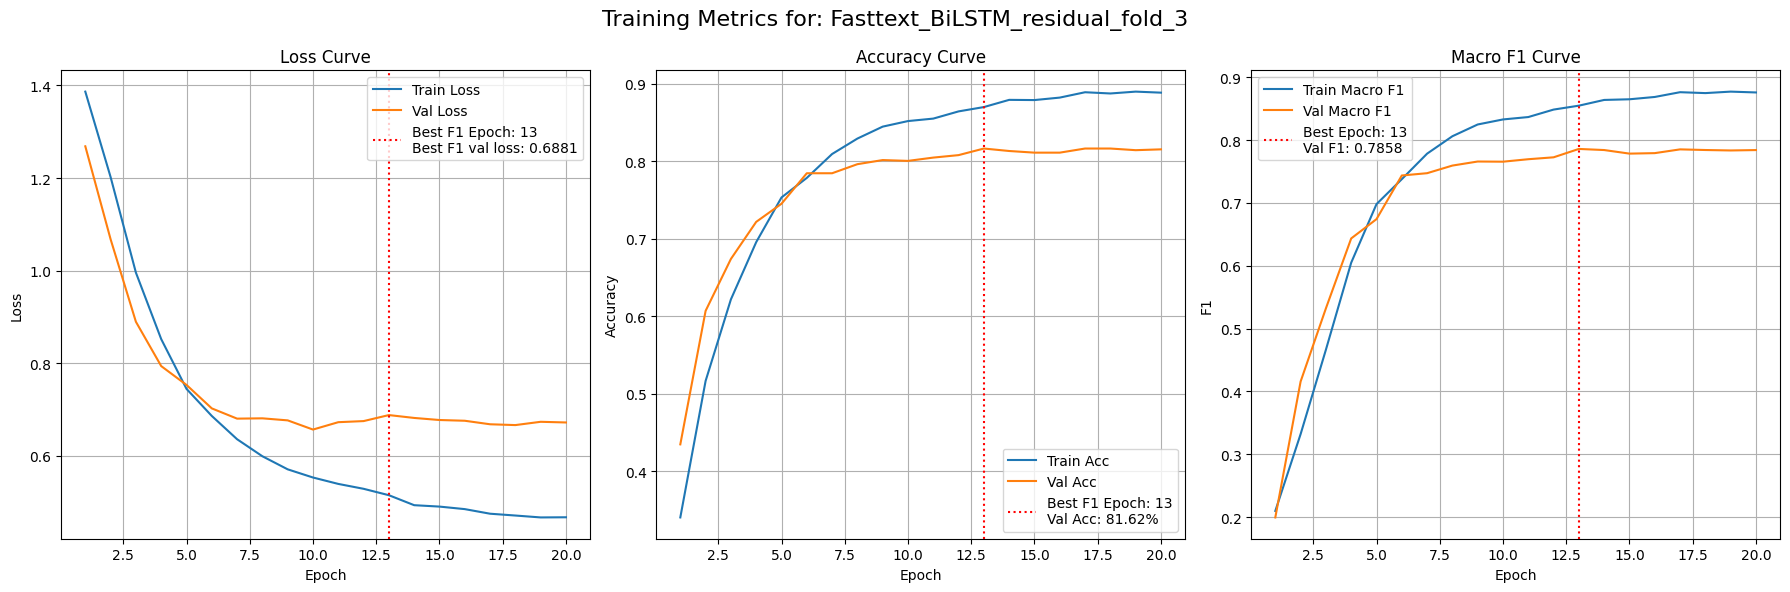

  Logging Fold 3 results under run_id: 9fc464c2f274456187892cb883a18aec
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_residual_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7403621275253155
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.82      0.97      0.89       379
LIGHT_PROFANITY       0.78      0.64      0.70       187
 HIGH_PROFANITY       0.74      0.74      0.74       120
       VIOLENCE       0.87      0.76      0.81       255

       accuracy                           0.82       941
      macro avg       0.80      0.78      0.79       941
   weighted avg       0.82      0.82      0.81       941

PR curve will be saved as Fasttext_BiLSTM_residual_fold_3_PR.png


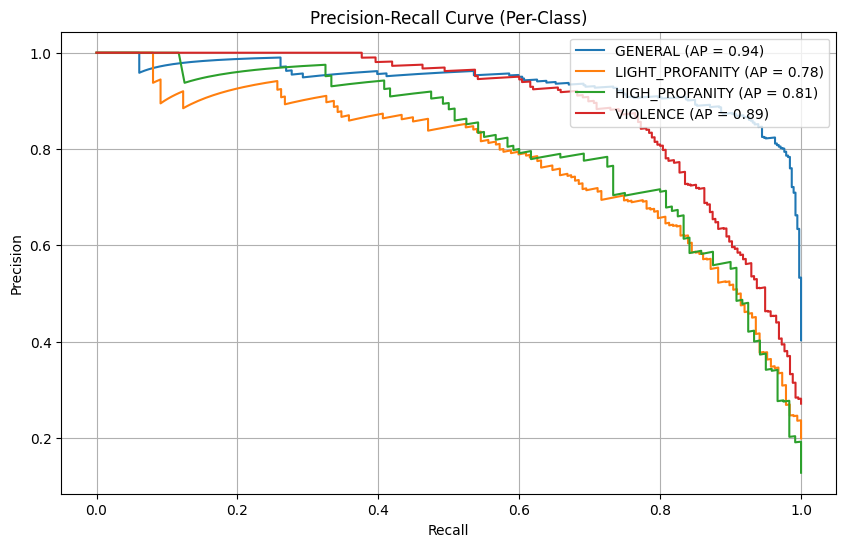

Confusion Matrix will be saved as Fasttext_BiLSTM_residual_fold_3_cm.png


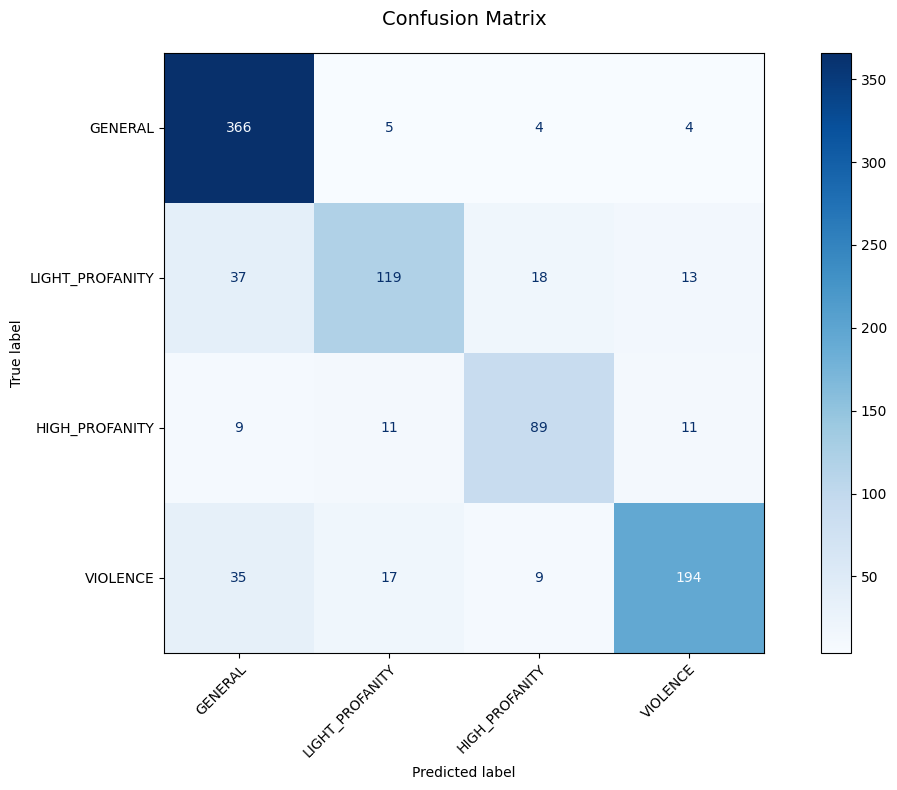

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/9fc464c2f274456187892cb883a18aec
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3543 | Val Loss: 1.2479 | Train F1: 0.2435 | Val F1: 0.2591
Epoch 2/20 | Train Loss: 1.1885 | Val Loss: 1.0479 | Train F1: 0.3380 | Val F1: 0.3630
Epoch 3/20 | Train Loss: 1.0034 | Val Loss: 0.8910 | Train F1: 0.4694 | Val F1: 0.5622
Epoch 4/20 | Train Loss: 0.8539 | Val Loss: 0.7555 | Train F1: 0.6054 | Val F1: 0.6972
Epoch 5/20 | Train Loss: 0.7525 | Val Loss: 0.7002 | Train F1: 0.6992 | Val F1: 0.7430
Epoch 6/20 | Train Loss: 0.6736 | Val Loss: 0.6760 | Train F1: 0.7540 | Val F1: 0.7659
Epoch 7/20 | Train Loss: 0.6325 | Val Loss: 0.6505 | Train F1: 0.7764 | Val F1: 0.7713
Epoch 8/20 | Train Loss: 0.6027 | Val Loss: 0.6547 | Train F1: 0.7872 | Val F1: 0.7736
Epoch 9/20 | Train Loss: 0.5783 | Val Loss: 0.636

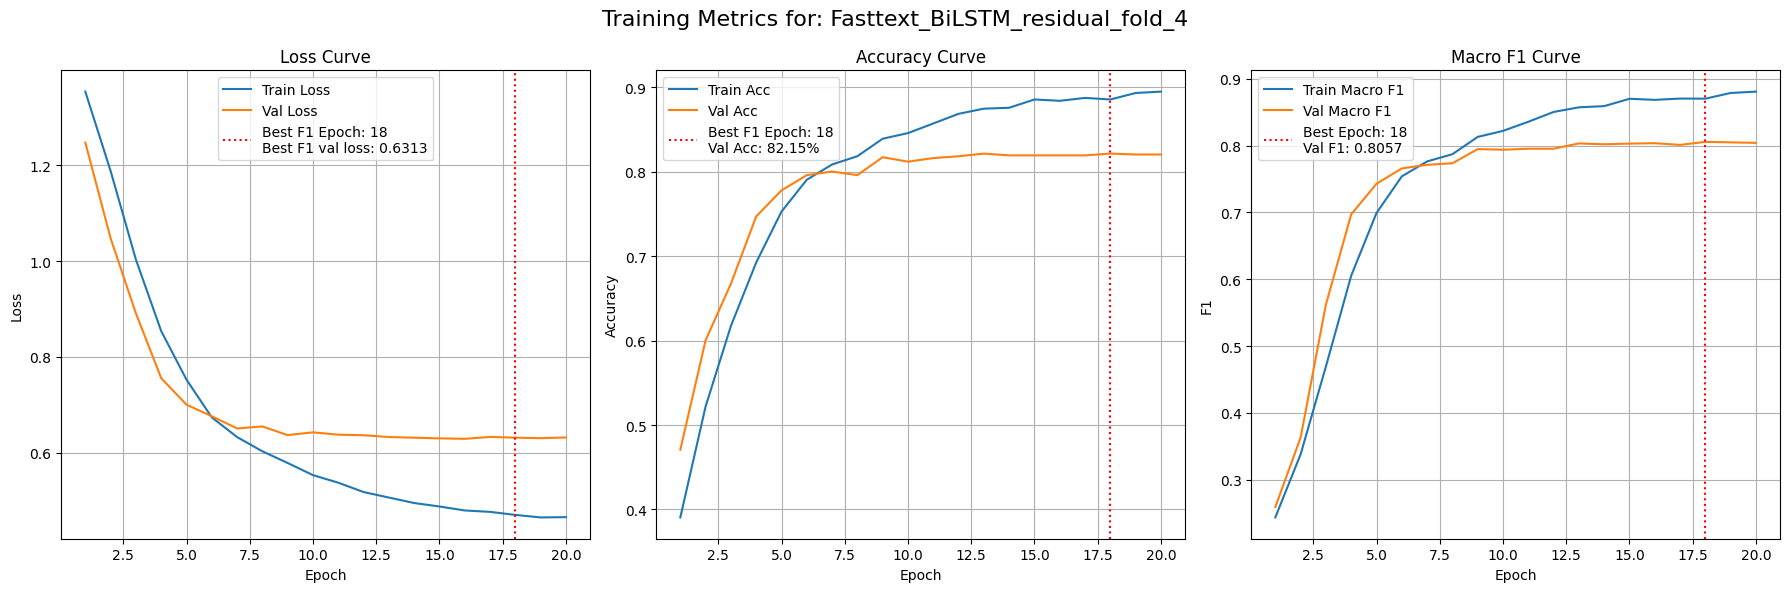

  Logging Fold 4 results under run_id: f0f175bfab0c43cc81125281ec8ea92b
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_residual_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7483464086265933
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.87      0.86       378
LIGHT_PROFANITY       0.73      0.72      0.73       188
 HIGH_PROFANITY       0.77      0.81      0.79       120
       VIOLENCE       0.86      0.83      0.84       255

       accuracy                           0.82       941
      macro avg       0.80      0.81      0.81       941
   weighted avg       0.82      0.82      0.82       941

PR curve will be saved as Fasttext_BiLSTM_residual_fold_4_PR.png


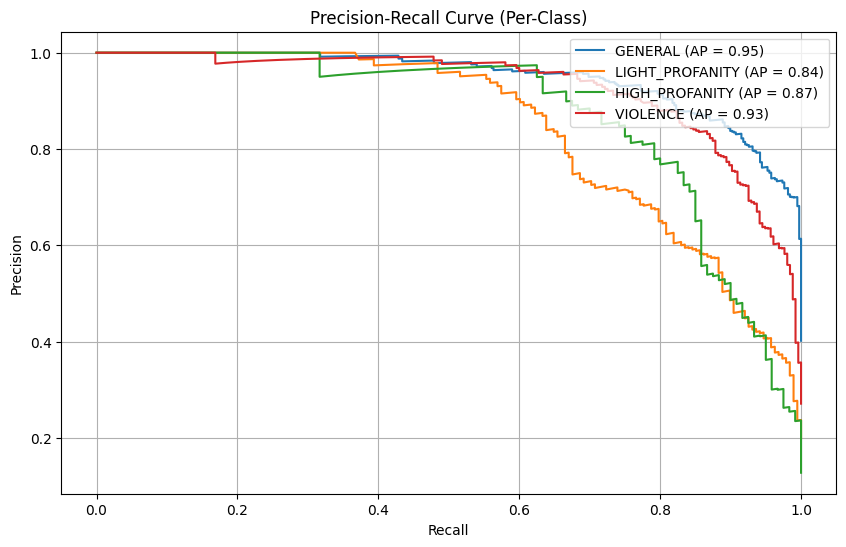

Confusion Matrix will be saved as Fasttext_BiLSTM_residual_fold_4_cm.png


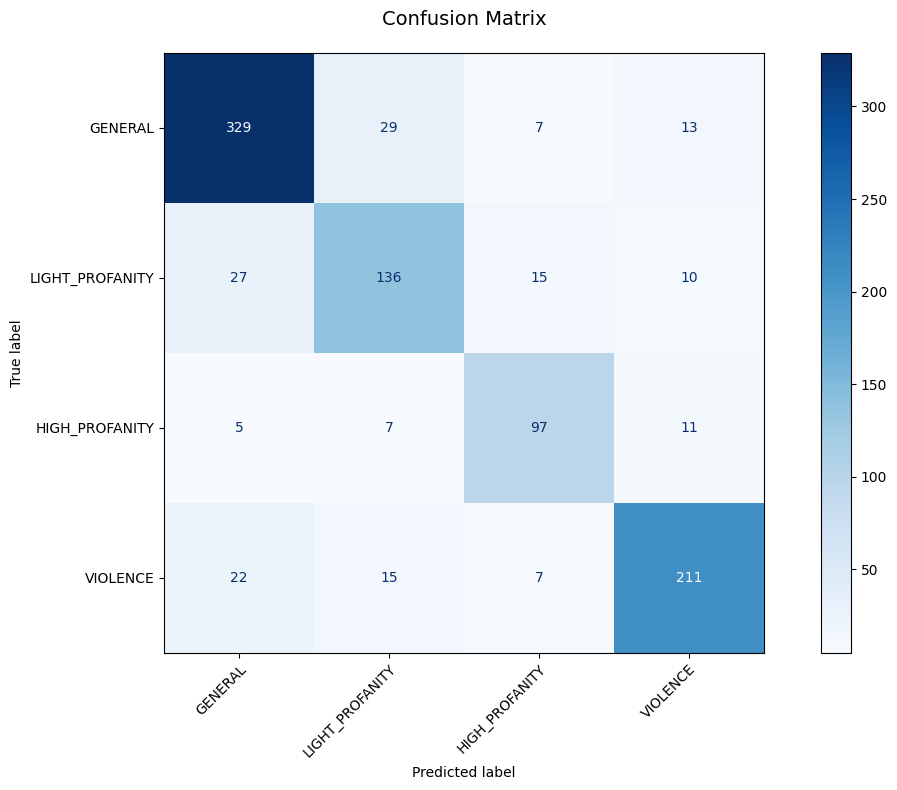

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/f0f175bfab0c43cc81125281ec8ea92b
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3738 | Val Loss: 1.2914 | Train F1: 0.2149 | Val F1: 0.2051
Epoch 2/20 | Train Loss: 1.2161 | Val Loss: 1.0908 | Train F1: 0.3235 | Val F1: 0.3930
Epoch 3/20 | Train Loss: 1.0127 | Val Loss: 0.9015 | Train F1: 0.4592 | Val F1: 0.5286
Epoch 4/20 | Train Loss: 0.8525 | Val Loss: 0.7927 | Train F1: 0.6145 | Val F1: 0.6356
Epoch 5/20 | Train Loss: 0.7347 | Val Loss: 0.7373 | Train F1: 0.7094 | Val F1: 0.7053
Epoch 6/20 | Train Loss: 0.6604 | Val Loss: 0.7097 | Train F1: 0.7662 | Val F1: 0.7255
Epoch 7/20 | Train Loss: 0.6174 | Val Loss: 0.6912 | Train F1: 0.7979 | Val F1: 0.7508
Epoch 8/20 | Train Loss: 0.5831 | Val Loss: 0.6882 | Train F1: 0.8069 | Val F1: 0.7576
Epoch 9/20 | Train Loss: 0.5657 | Val Loss: 0.666

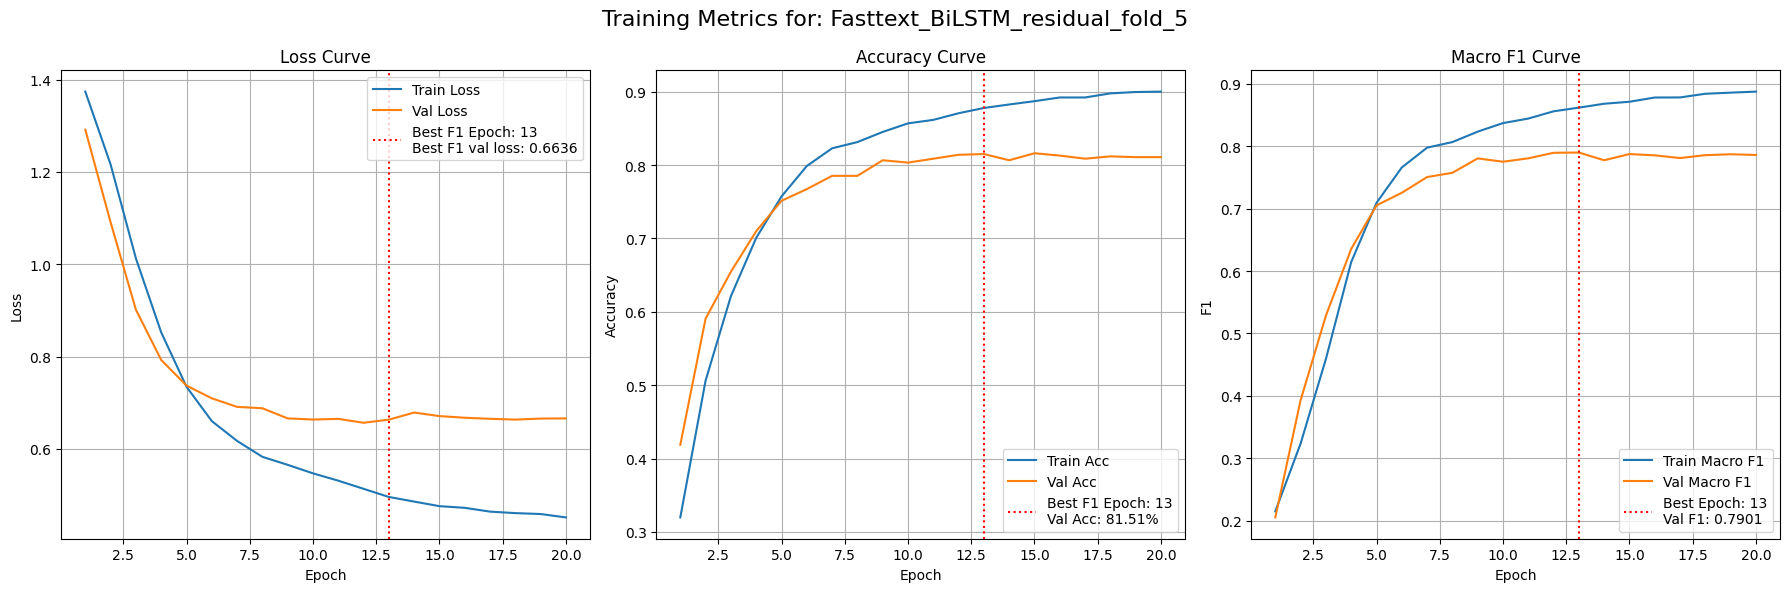

  Logging Fold 5 results under run_id: 8b58f16351184f718b321284374cbfde
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/Fasttext_BiLSTM_residual_fold_5_state_dict.pt
Matthews correlation coefficient: 0.737767762715518
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.92      0.89       378
LIGHT_PROFANITY       0.71      0.76      0.73       188
 HIGH_PROFANITY       0.84      0.67      0.74       120
       VIOLENCE       0.81      0.78      0.79       255

       accuracy                           0.82       941
      macro avg       0.81      0.78      0.79       941
   weighted avg       0.82      0.82      0.81       941

PR curve will be saved as Fasttext_BiLSTM_residual_fold_5_PR.png


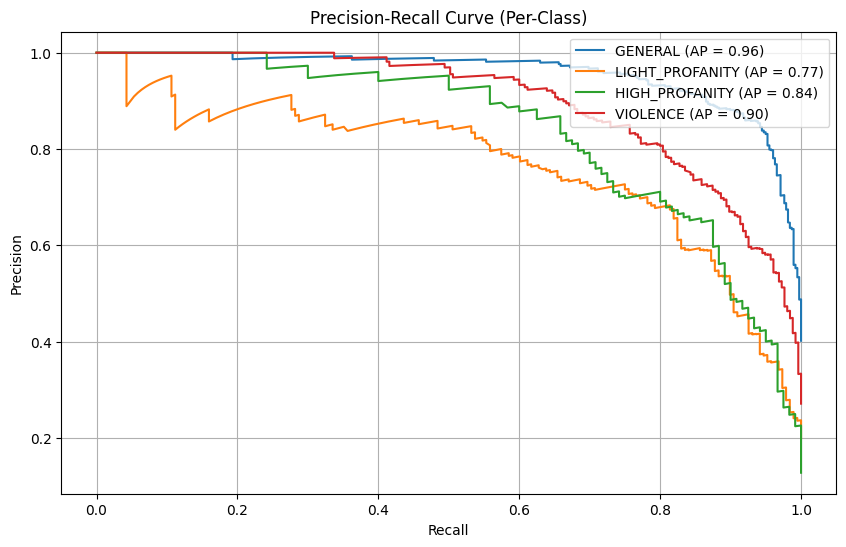

Confusion Matrix will be saved as Fasttext_BiLSTM_residual_fold_5_cm.png


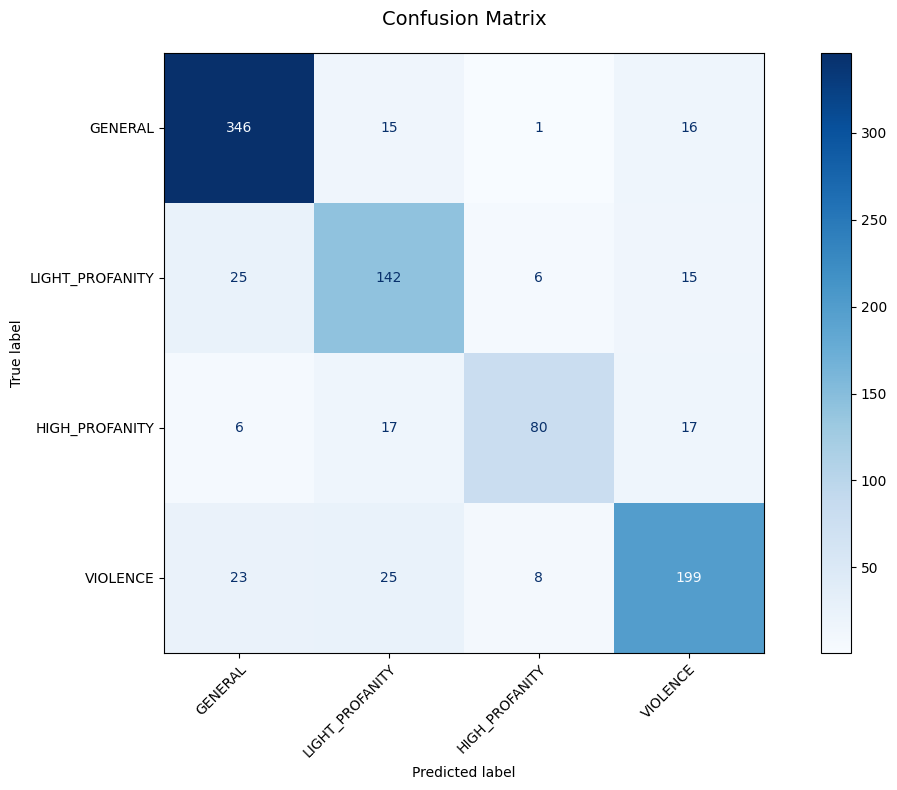

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/8b58f16351184f718b321284374cbfde
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for Fasttext_BiLSTM_residual across 5 folds...
Overall Results for Fasttext_BiLSTM_residual:
  Avg Accuracy: 0.8247
  Avg Macro F1: 0.8029
  Avg Macro precision: 0.8130
  Avg Macro recall: 0.7965
  Avg Weighted F1: 0.8229
  Avg MCC: 0.7520

Performing Overall Out-of-Fold Evaluation for Fasttext_BiLSTM_residual...
Overall Out-of-Fold Classification Report for Fasttext_BiLSTM_residual:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.92      0.88      1893
LIGHT_PROFANITY       0.75      0.71      0.73       938
 HIGH_PROFANITY       0.79      0.76      0.78       601
       VIOLENCE       0.85      0.80      0.82      1275

       accuracy                           0.82    

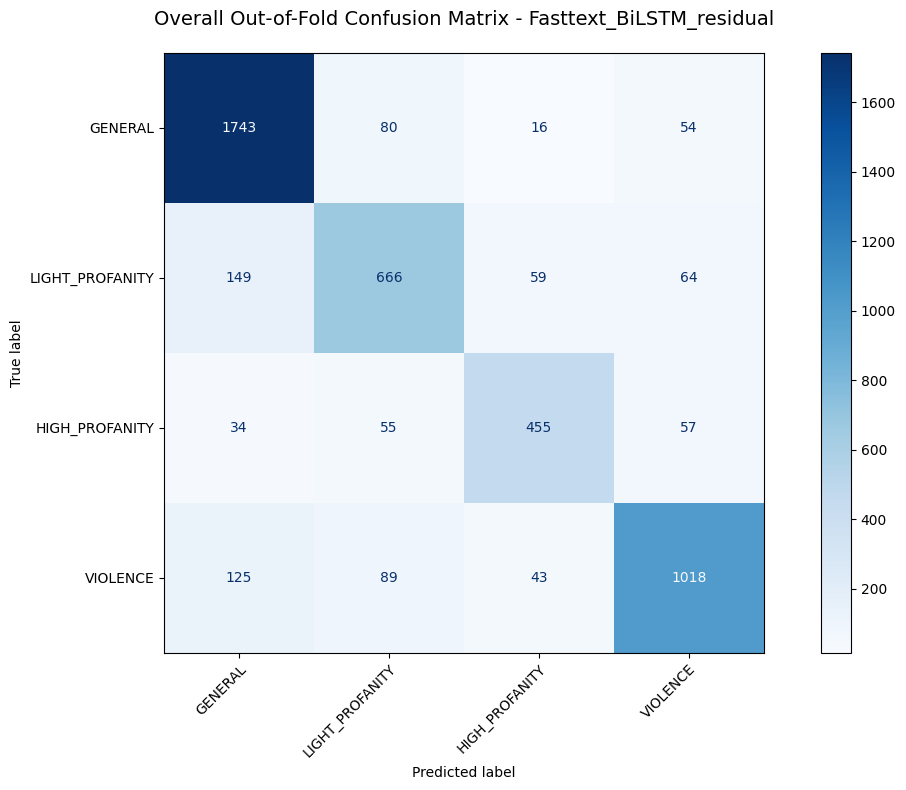

🏃 View run Fasttext_BiLSTM_residual at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/cdfd33eef0b242c9a82f36aec3f1325f
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [20]:
ResLSTM_cv_outputs = run_cross_validation(architectures_to_test[3], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)